# Information on How These Data Are Organized:

`TypeOfResponse` refers to whether participants pressed a button ("SCResp") or did not press a button ("SCRespITI") within the given time frame.

`Version` refers to the task version - these are counterbalanced across the 2 conditions (feedback (7-12)/no feedback(1-6)). We also counterbalanced for block order: version 3 & 9: MIC-MIC-MC-MC; version 4 & 10: MC-MC-MIC-MIC. Pilot analyses suggested that this order of "extending" the block length (back-to-back context) helped participants learn better, so we did not run all possible block orders (e.g., versions 1-2, 5-6, 7-8, 11-12). Unlike in the ISPC, image assignment to the PC manipulation was randomized across participants.

`LogCounter` gets added to whenever the JS records a new datapoint.

`TrialCounter` gets added to whenever a new trial has started. This is reset at the start of each block.

`MatrixCounter` gets added to throughout the task and is never reset. It is what I use to call Stimuli #s.

`RunCounter` refers to the run. The first run was a practice run of 120 images (20/key) without the distractor word printed on any, just so participants were acclimated to the S-R mappings. Afterwards, each run was its own mostly congruent or incongruent block, consistent with Bugg et al. (2011). This meant that only 4/6 items were presented in each run.

`TrialType` refers to whether the trial was a congruent (1) or incongruent trial (0).

`ContextType` refers to whether the block/run is a mostly incongruent (1) or mostly congruent (0) context.

`ItemType` refers to whether the image is PC-85 (1), PC-15 (2), or PC-50 (3).

`ImagePresented` refers to the image on each trial; `WordPresented` is the word on each trial.

`StroopNum` just refers to the combinations present. In this experiment we controlled for contingency learning by having each image have only one incongruent and congruent stimulus. So, there are only 12 pairings (3 item types, 2 images per item type, 2 trial types).

`PressCorrect` refers to the button that participants should press on that trial. This is how I define accuracy (i.e., correct: when PressCorrect = actualkeyPressed).

`ActualKeyPressed` is what key subjects pressed.

`Accuracy` & `RT` self-explanatory.

`FeedbackType` refers to whether they got correct as fb (1), incorrect as fb (2), or the fb time-out (3). In the No Feedback condition, they only get the feedback time-out.

`runStart` refers to the initiation of the countdown to begin the block; `ITI/FBOnset` refers to when the ITI or feedback was triggered; `StimTime` refers to when the image was presented;  `RespOnset` refers to when a response was made.

`AccCount` is how I give subjects accurate fb of their performance at the end of each run (i.e., a counter that gets added to after each correct trial & is divided by trial #).

`Subject` self-explanatory.

`StimRep` looks for direct stimulus repetitions (StroopNum).

---

### Here we'll just import Python specific packages and read in our data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plb
import math
from scipy import stats

%matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%cd C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\lwpc_combined\data
dat = pd.read_csv('AllSubsSC.csv')
#setting path for where I can a) find data and b) write csv files if I want to look more closely at the data
csvpath='C:\\Users\\cb383\\Desktop\\YearThree\\controllearning\\fbproject\\lwpc_combined\\data\\csvdata\\'

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\lwpc_combined\data


# Do Some Basic Cleaning

#### We are filtering and preparing the data for analysis.

FOR REACTION TIMES:

-Select only `TypeOfResponse` equal to `Resp` (`ITI Resp` is when subs didn't respond).

-Only take the RTs that are greater than 200ms and less than 1000 ms (filtering out too fast responses; it's overkill, probably, to have the <1000 ms filter, because those trials should be marked as ITI Resp, but just in case).

-Only take the RTs on accurate trials.

-Only take trials where the stimulus didn't repeat.


FOR ACCURACY:

-All errors are errors

In [3]:
cdat = dat.query('(TypeOfResponse != "SCRespITI") & (RT > 200) & (RT < 1000) & (Accuracy != 0) & (StimRep != 1)').copy()
adat = dat.copy()

#### Now I'm making columns in the data based off my variables so that analysis will be easier and understandable by other folks.

In [8]:
dataframes = [cdat, adat];

for df in dataframes:
    #create new boolean column & then relabel it with conditions
    df['Feedback'] = df['Version'].isin([3,4,9,10])
    df.loc[df['Version'].isin([9,10]), 'Feedback'] = 'Feedback'
    df.loc[df['Version'].isin([3,4]), 'Feedback'] = 'NoFeedback'
    
    df['BlockOrder'] = df['Version'].isin([3,4,9,10])
    df.loc[df['Version'].isin([3,9]), 'BlockOrder'] = 'IncongFirst'
    df.loc[df['Version'].isin([4,10]), 'BlockOrder'] = 'CongFirst'
    
    df['Task'] = df['RunCounter'].isin([4])
    df.loc[df['RunCounter'].isin([0]), 'Task'] = 'Practice'
    df.loc[df['RunCounter'].isin([1,2,3,4]), 'Task'] = 'Main'
    
    df['BlockType'] = df['ContextType'].isin([0])
    df.loc[df['ContextType'].isin([1]), 'BlockType'] = 'PC-25'
    df.loc[df['ContextType'].isin([0]), 'BlockType'] = 'PC-75'

    df['Congruency'] = df['TrialType'].isin([1])
    df.loc[df['TrialType'].isin([0]),'Congruency'] = 'Incongruent'
    df.loc[df['TrialType'].isin([1]),'Congruency'] = 'Congruent'
    
    df['Item'] = df['ItemType'].isin([1])
    df.loc[df['ItemType'].isin([1]),'Item'] = 'PC-85'
    df.loc[df['ItemType'].isin([2]),'Item'] = 'PC-15'
    df.loc[df['ItemType'].isin([3]),'Item'] = 'PC-50'
    
    df['ContextCong'] = df['BlockType'].isin(['High']) & df['TrialType'].isin([1])
    df.loc[(df['BlockType'].isin(['PC-25']) & df['TrialType'].isin([0])), 'ContextCong'] = 'HighIC'
    df.loc[(df['BlockType'].isin(['PC-75']) & df['TrialType'].isin([0])), 'ContextCong'] = 'LowIC'
    df.loc[(df['BlockType'].isin(['PC-25']) & df['TrialType'].isin([1])), 'ContextCong'] = 'HighC'
    df.loc[(df['BlockType'].isin(['PC-75']) & df['TrialType'].isin([1])), 'ContextCong'] = 'LowC'

# Look at Mean Cueing Effects

### In this list-wide proportion congruent paradigm, we would expect to find a congruency by proportion congruent interaction such that there is a reduced congruency difference for "low" proportion congruent blocks vs. "high" proportion congruent blocks. The basic idea is that participants learn to adjust their attentional priorities for the context they are currently in, and they need to recruit more attentional focus in the low PC condition.

### However, some LWPC paradigms cannot distinguish between list-wide and item-specific contributions to these control adjustments. To do so, you must have biased item-specific images/items (e.g., PC-85/15) and unbiased items (PC-50). Then, you manipulate the proportions of the biased items to create an overall list-level proportion (e.g., PC-75/25) - the biased items are then biased at the list and item level, whereas the unbiased items are only biased at the list level. This is the design we adopted.

### Here we are looking to replicate a picture-word biased LWPC/ISPC effect (like our ISPC expt) and an unbiased LWPC effect, and we are also investigating the effects of performance feedback on the LWPC effect. Because participants can figure out the context in which they are in (e.g., higher proportion of "hard"/incongruent trials), the LWPC is thought to reflect proactive control or control that is recruited in anticipation of temporal demand. Proactive control is thought to be "costly" to recruit. It has thus been hypothesized that proactive control is particularly sensitive to reward (like performance feedback); our previous ISPC study suggested that feedback did not impact the ISPC (thought to reflect reactive control), so we're now testing whether proactive control, via the LWPC, is affected by performance feedback. You'd expect that if the LWPC truly reflects proactive control, and proactive control is costly, we'd see that the Feedback Group shows an unbiased LWPC effect ("rewarded" to recruit proactive control), while the No Feedback Group does not ("costly" to recruit proactive control).

In [9]:
def mean_cueing_effect(df, dv, Filter1, Filter2, Filter3, Context):
    if Context == 1:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']==Filter2].loc[df['Feedback']==Filter3].groupby(['subject','ContextCong'])[dv].mean()
    elif Context == 2:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']!=Filter2].loc[df['Feedback']==Filter3].groupby(['subject','ContextCong'])[dv].mean()
    elif Context == 3:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']==Filter2].loc[df['Feedback']==Filter3].groupby(['subject','CSE'])[dv].mean()
    elif Context == 4:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']!=Filter2].loc[df['Feedback']==Filter3].groupby(['subject','CSE'])[dv].mean()
    grpmean = pd.Series.mean(sub_means, level=1)
    nsubs = math.sqrt(len(sub_means))
    grpstd = pd.Series.std(sub_means, level=1)
    sem = grpstd / nsubs
    return grpmean, sem

In [10]:
mean_cueing_effect(cdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 1) #PC-50/50

(ContextCong
 HighC     657.982251
 HighIC    676.292296
 LowC      653.968907
 LowIC     674.491089
 Name: RT, dtype: float64, ContextCong
 HighC     4.008263
 HighIC    4.090756
 LowC      4.127900
 LowIC     4.169860
 Name: RT, dtype: float64)

In [11]:
mean_cueing_effect(cdat, 'RT', 'Main', 'PC-50', 'Feedback', 1) #PC-50/50

(ContextCong
 HighC     665.273598
 HighIC    677.092168
 LowC      656.601688
 LowIC     676.143805
 Name: RT, dtype: float64, ContextCong
 HighC     3.303862
 HighIC    3.280269
 LowC      3.382585
 LowIC     3.261099
 Name: RT, dtype: float64)

What about the biased items?

In [12]:
mean_cueing_effect(cdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 2) #PC-85/15

(ContextCong
 HighC     612.971537
 HighIC    626.182870
 LowC      609.257851
 LowIC     636.648488
 Name: RT, dtype: float64, ContextCong
 HighC     4.280557
 HighIC    4.019596
 LowC      3.981102
 LowIC     4.158630
 Name: RT, dtype: float64)

In [13]:
mean_cueing_effect(cdat, 'RT', 'Main', 'PC-50', 'Feedback', 2) #PC-85/15

(ContextCong
 HighC     624.184386
 HighIC    628.440515
 LowC      619.838320
 LowIC     641.600697
 Name: RT, dtype: float64, ContextCong
 HighC     3.640730
 HighIC    3.329518
 LowC      3.260069
 LowIC     3.374076
 Name: RT, dtype: float64)

#### Now, what of Accuracy?

In [14]:
mean_cueing_effect(adat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 1) #PC-50/50

(ContextCong
 HighC     0.883056
 HighIC    0.853333
 LowC      0.885000
 LowIC     0.868056
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.005788
 HighIC    0.007179
 LowC      0.005852
 LowIC     0.006616
 Name: Accuracy, dtype: float64)

In [15]:
mean_cueing_effect(adat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 1) #PC-50/50

(ContextCong
 HighC     0.892619
 HighIC    0.883276
 LowC      0.887349
 LowIC     0.860000
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.004719
 HighIC    0.004437
 LowC      0.006026
 LowIC     0.006721
 Name: Accuracy, dtype: float64)

Biased Items for Accuracy...

In [16]:
mean_cueing_effect(adat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 2) #PC-85/15

(ContextCong
 HighC     0.919792
 HighIC    0.902715
 LowC      0.934217
 LowIC     0.865278
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.004826
 HighIC    0.005393
 LowC      0.003381
 LowIC     0.006800
 Name: Accuracy, dtype: float64)

In [17]:
mean_cueing_effect(adat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 2) #PC-85/15

(ContextCong
 HighC     0.912153
 HighIC    0.923645
 LowC      0.934953
 LowIC     0.874306
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.003996
 HighIC    0.003528
 LowC      0.002816
 LowIC     0.006285
 Name: Accuracy, dtype: float64)

#### Let's dig a little deeper now.

## Run Repeated-Measures ANOVAs in R

Please check out the R notebook entitled `RANOVAs` in the same folder as this jupyter notebook. This python magic wants to run R version 3.4.3, which is not compatible with the `afex` R package, while my R notebooks do indeed open to R version 3.5.1. So, that will have the RM anovas and Bayesian anovas as well.

In [14]:
%cd csvdata

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\lwpc_combined\data\csvdata


In [15]:
RTmeans = cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'Feedback', 'BlockOrder', 'Experiment'])['RT'].mean().reset_index();
ACCmeans = adat.loc[adat['Task']=='Main'].loc[adat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'Feedback', 'BlockOrder', 'Experiment'])['Accuracy'].mean().reset_index();

RTmeans_PC50 = cdat.loc[cdat['Task']=='Main'].loc[cdat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'Feedback', 'BlockOrder', 'Experiment'])['RT'].mean().reset_index();
ACCmeans_PC50 = adat.loc[adat['Task']=='Main'].loc[adat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'Feedback', 'BlockOrder', 'Experiment'])['Accuracy'].mean().reset_index();

RTmeans.to_csv(csvpath+'SC_ANOVA_RT.csv')
ACCmeans.to_csv(csvpath+'SC_ANOVA_ACC.csv')

RTmeans_PC50.to_csv(csvpath+'SCT_ANOVA_RT.csv')
ACCmeans_PC50.to_csv(csvpath+'SCT_ANOVA_ACC.csv')

In [16]:
%%writefile SCAnova.R

install.packages("afex",repos='https://mirrors.nics.utk.edu/cran/')
library(afex)

rawRTData <- read.csv('SC_ANOVA_RT.csv')

#don't need to specify within-subs factors outside Error term with this package
#no observed factors here instead of experimentally manipulated, so I did not add observed="..."
#also don't need to factorize the data with this package
aov_car(RT ~ Feedback * Experiment * BlockOrder + Error(subject/(Congruency*BlockType)), data = rawRTData, anova_table = list(es = "pes"))

#

rawRTData_T <- read.csv('SCT_ANOVA_RT.csv')
aov_car(RT ~ Feedback * Experiment * BlockOrder + Error(subject/(Congruency*BlockType)), data = rawRTData_T, anova_table = list(es = "pes"))

#

rawACCData <- read.csv('SC_ANOVA_ACC.csv')
aov_car(Accuracy ~ Feedback * Experiment * BlockOrder + Error(subject/(Congruency*BlockType)), data = rawACCData, anova_table = list(es = "pes"))

#

rawACCData_T <- read.csv('SCT_ANOVA_ACC.csv')
aov_car(Accuracy ~ Feedback * Experiment * BlockOrder + Error(subject/(Congruency*BlockType)), data = rawACCData_T, anova_table = list(es = "pes"))

Overwriting SCAnova.R


In [ ]:
! Rscript SCAnova.R

We observe a context x congruency effect for the unbiased items for RT and context x congruency x feedback and context x congruency x block order interactions for Accuracy. What does this look like graphically? And is this like the ISPC effect, where there was a big RT/ACC trade-off?

# Look at the Results Graphically

In [18]:
figurepath='C:\\Users\\cb383\\Desktop\\YearThree\\controllearning\\fbproject\\lwpc_combined\\data\\figures\\'
sns.set(context='notebook', style='ticks', font='Myriad Pro', font_scale=2.5, color_codes=False, rc=None);

In [19]:
def mybargraph(x,y,hue,col,order,data,xlabel,ylabel,title,legendtitle,ymin,ymax,figname,stepsize):
    g = sns.catplot(x=x, 
                       y=y, 
                       hue=hue,
                       col=col,
                       order=order,
                       data=data,
                       palette="colorblind",
                       ci=68, 
                       kind="bar",
                       height=10, 
                       aspect=.7,
                       saturation=0.6,
                       legend_out = True);
    g.set_axis_labels(xlabel, ylabel);
    g.despine(left=True);

    # check axes and find which have legends
    for ax in g.axes.flat:
        leg = g.axes.flat[0].get_legend()
        if not leg is None: 
            break
    
    # or legend may be on a figure
    if leg is None: 
        leg = g._legend

    leg.set_title(legendtitle);
    g.set(ylim=(ymin, ymax), yticks=np.arange(ymin,ymax+stepsize,stepsize))
    g.fig.suptitle(title, y = 1.05)
    
    titles = ["No Feedback Group", "Feedback Group"]
    for ax, title in zip(g.axes.flat, titles):
        ax.set_title(title)
        
    plb.savefig(figurepath+figname, dpi=300, bbox_inches='tight')

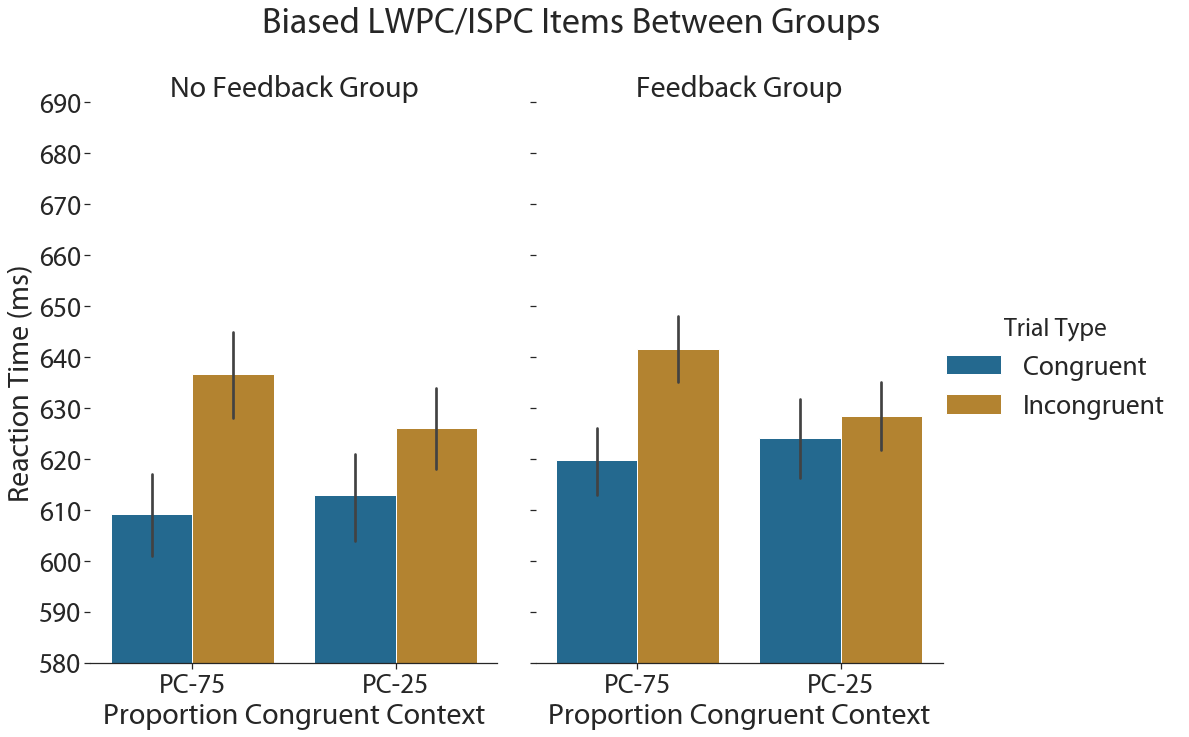

In [22]:
mybargraph("BlockType","RT","Congruency","Feedback",["PC-75", "PC-25"],RTmeans,"Proportion Congruent Context","Reaction Time (ms)","Biased LWPC/ISPC Items Between Groups","Trial Type",580,690,"LWPC_RT_maintask.png",10)

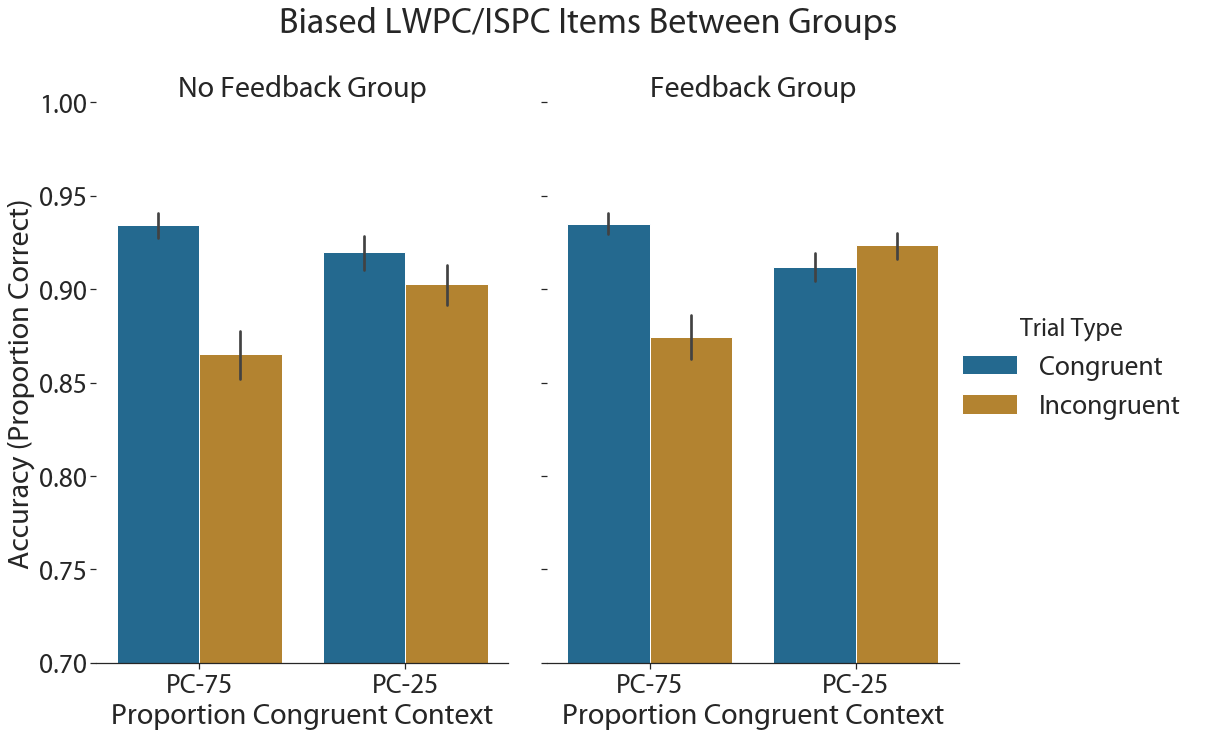

In [23]:
mybargraph("BlockType","Accuracy","Congruency","Feedback",["PC-75", "PC-25"],ACCmeans,"Proportion Congruent Context","Accuracy (Proportion Correct)","Biased LWPC/ISPC Items Between Groups","Trial Type",0.7,1.0,"LWPC_ACC_maintask.png",0.05)

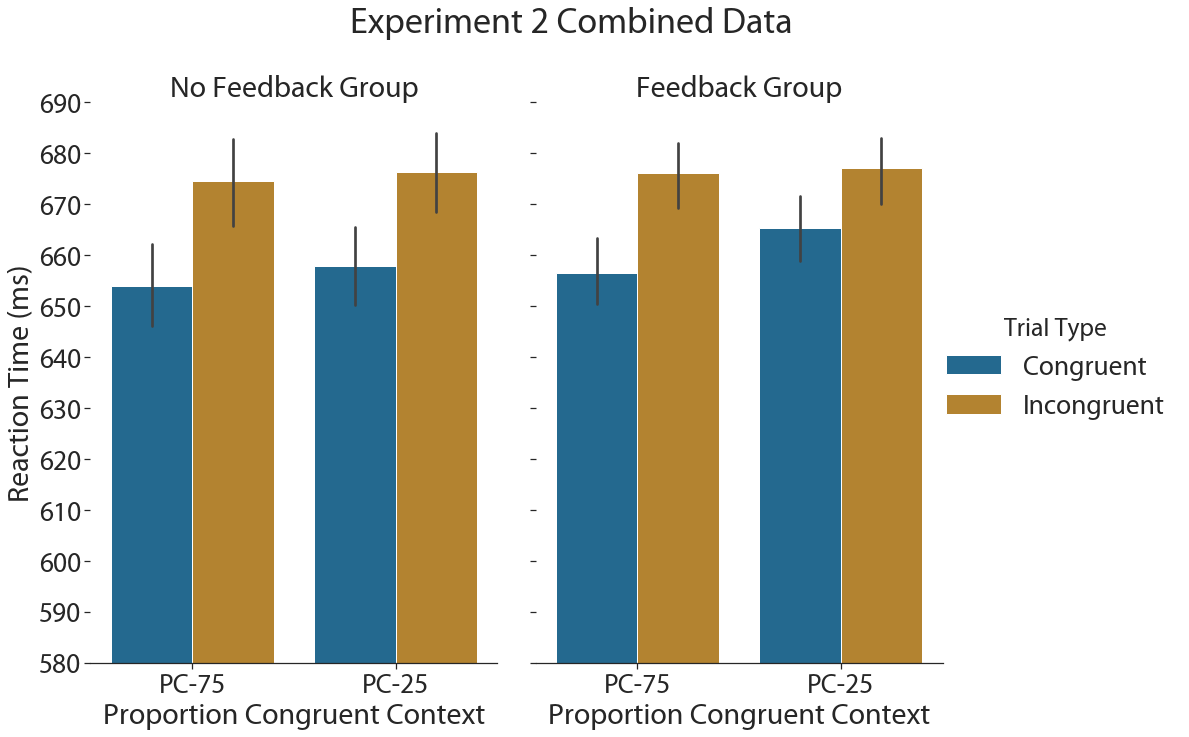

In [24]:
mybargraph("BlockType","RT","Congruency","Feedback",["PC-75", "PC-25"],RTmeans_PC50,"Proportion Congruent Context","Reaction Time (ms)","Experiment 2 Combined Data","Trial Type",580,690,"LWPC_RT_pc50.png",10)

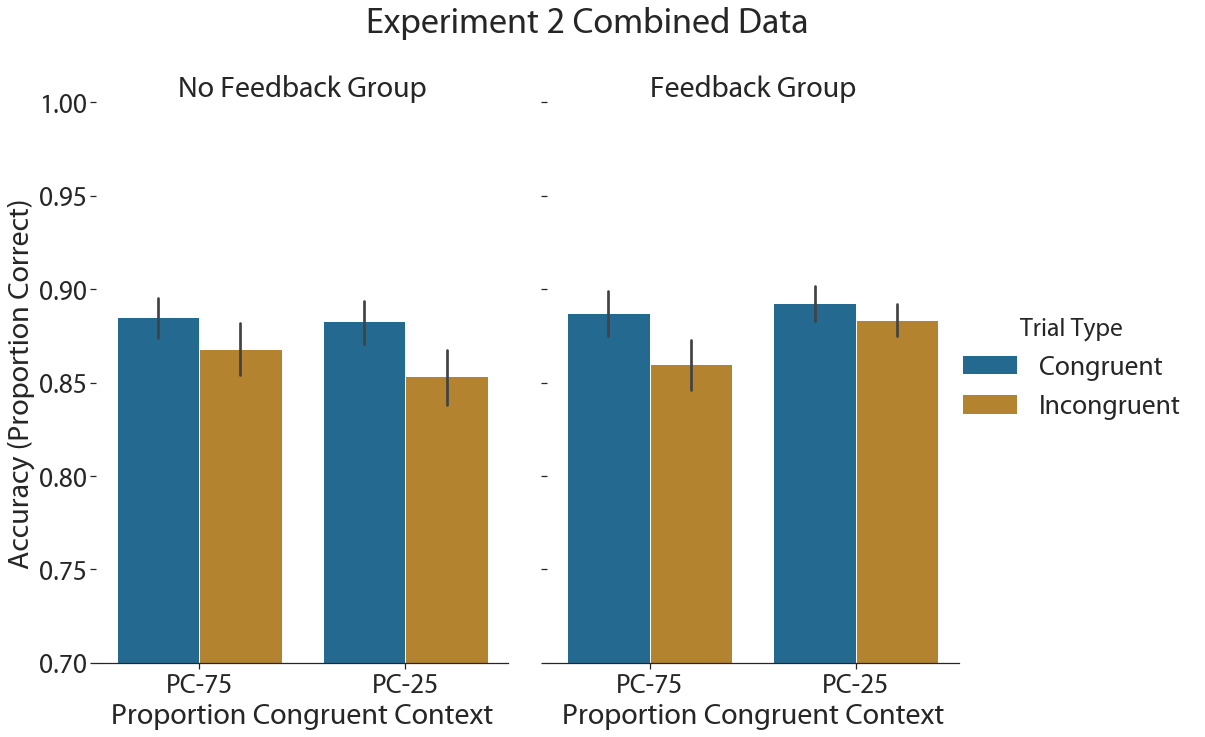

In [25]:
mybargraph("BlockType","Accuracy","Congruency","Feedback",["PC-75", "PC-25"],ACCmeans_PC50,"Proportion Congruent Context","Accuracy (Proportion Correct)","Experiment 2 Combined Data","Trial Type",0.7,1.0,"LWPC_ACC_pc50.png",0.05)

# Creating Variables

##### this is to calculate the interaction effects for later correlation graphs, with overall RT/acc in each condition serving as a correction
##### also used to calculate inverse efficiency scores, test RT/acc trade-off

In [26]:
FBsubslim = 180;
NoFBsubslim = 90; #subs 1-90 in the list are no fb grp, while 91-180 are fb

In [27]:
#needed to be outside the function because python wasn't recognizing the dfname as an input when dfname = pd.DataFrame()
FB_RT = pd.DataFrame();
NoFB_RT = pd.DataFrame();
FB_ACC = pd.DataFrame();
NoFB_ACC = pd.DataFrame();

In [28]:
def create_wide_df(df,dfname,dv,Group,lim1,lim2):
    lists = [[] for list in range(0,9)]
    data_filter = df[df.Task=='Main'];
    data = data_filter[data_filter.Feedback == Group]
    
    for ID in range(lim1, lim2):
        sub = data[data.subject == ID]
        lists[0].append(ID)
        submain = sub[sub.Item != 'PC-50']
        LowC_trials = submain[submain.ContextCong == 'LowC'][dv].mean()
        LowIC_trials = submain[submain.ContextCong == 'LowIC'][dv].mean()
        HighC_trials = submain[submain.ContextCong == 'HighC'][dv].mean()
        HighIC_trials = submain[submain.ContextCong == 'HighIC'][dv].mean()
        subtransfer = sub[sub.Item == 'PC-50']
        LowC_trials_T = subtransfer[subtransfer.ContextCong == 'LowC'][dv].mean()
        LowIC_trials_T = subtransfer[subtransfer.ContextCong == 'LowIC'][dv].mean()
        HighC_trials_T = subtransfer[subtransfer.ContextCong == 'HighC'][dv].mean()
        HighIC_trials_T = subtransfer[subtransfer.ContextCong == 'HighIC'][dv].mean()
        lists[1].append(LowC_trials)
        lists[2].append(LowIC_trials)
        lists[3].append(HighC_trials)
        lists[4].append(HighIC_trials)
        lists[5].append(LowC_trials_T)
        lists[6].append(LowIC_trials_T)
        lists[7].append(HighC_trials_T)
        lists[8].append(HighIC_trials_T)
        
    dfname['SubjectID'] = lists[0]
    dfname['LowC'] = lists[1]
    dfname['LowIC'] = lists[2]
    dfname['HighC'] = lists[3]
    dfname['HighIC'] = lists[4]
    dfname['LowC_T'] = lists[5]
    dfname['LowIC_T'] = lists[6]
    dfname['HighC_T'] = lists[7]
    dfname['HighIC_T'] = lists[8]

In [29]:
create_wide_df(cdat,FB_RT,'RT','Feedback',NoFBsubslim+1,FBsubslim+1);

In [30]:
create_wide_df(cdat,NoFB_RT,'RT','NoFeedback',1,NoFBsubslim+1);

In [31]:
create_wide_df(adat,FB_ACC,'Accuracy','Feedback',(NoFBsubslim+1),(FBsubslim+1));

In [32]:
create_wide_df(adat,NoFB_ACC,'Accuracy','NoFeedback',1,NoFBsubslim+1);

In [33]:
def calc_PCbycong_interaction(df, transfer, RTacc):
    if transfer == 0:
        InteractionEffect = (df.LowIC - df.LowC) - (df.HighIC - df.HighC);
    elif transfer == 1:
        InteractionEffect = (df.LowIC_T - df.LowC_T) - (df.HighIC_T - df.HighC_T);
    
    InteractionEffect = InteractionEffect.reset_index();
    
    if RTacc == 1:
        InteractionEffect.columns = ['index', 'RTs']
    elif RTacc == 0:
        InteractionEffect.columns = ['index', 'ACC']
    
    return InteractionEffect

In [34]:
SC_RT_FB = calc_PCbycong_interaction(FB_RT, 0, 1)

In [35]:
SCT_RT_FB = calc_PCbycong_interaction(FB_RT, 1, 1)

In [36]:
SC_ACC_FB = calc_PCbycong_interaction(FB_ACC, 0, 0)

In [37]:
SCT_ACC_FB = calc_PCbycong_interaction(FB_ACC, 1, 0)

In [38]:
SC_RT_NoFB = calc_PCbycong_interaction(NoFB_RT, 0, 1)

In [39]:
SCT_RT_NoFB = calc_PCbycong_interaction(NoFB_RT, 1, 1)

In [40]:
SC_ACC_NoFB = calc_PCbycong_interaction(NoFB_ACC, 0, 0)

In [41]:
SCT_ACC_NoFB = calc_PCbycong_interaction(NoFB_ACC, 1, 0)

In [42]:
#interaction effects - both groups
SC_RT = SC_RT_NoFB.append(SC_RT_FB)
SC_ACC = SC_ACC_NoFB.append(SC_ACC_FB)
SCT_RT = SCT_RT_NoFB.append(SCT_RT_FB)
SCT_ACC = SCT_ACC_NoFB.append(SCT_ACC_FB)

In [43]:
def means_overall_group(df, filternum, filter1, filter2, dv):
    if filternum == 0:
        X = df.groupby(['subject'])[dv].mean().reset_index();       
    elif filternum == 1:
        X = df.loc[df['Task'] == 'Main'].loc[df['Item'] == filter1].groupby(['subject'])[dv].mean().reset_index();
    elif filternum == 2:
        X = df.loc[df['Task'] == 'Main'].loc[df['Item'] != filter1].groupby(['subject'])[dv].mean().reset_index();
    elif filternum == 3:
        X = df.loc[df['Task'] == 'Main'].loc[df['Item'] == filter1].loc[df['Feedback'] == filter2].groupby(['subject'])[dv].mean().reset_index()
    elif filternum == 4:
        X = df.loc[df['Task'] == 'Main'].loc[df['Item'] != filter1].loc[df['Feedback'] == filter2].groupby(['subject'])[dv].mean().reset_index()

        
    X = X.drop('subject',1)
    
    return X

In [44]:
overallRT = means_overall_group(cdat, 0, 0, 0, 'RT')

In [45]:
overallACC = means_overall_group(adat, 0, 0, 0, 'Accuracy')

In [46]:
overallMainRT = means_overall_group(cdat, 2, 'PC-50', 0, 'RT') #main refers to pc-85/15 here

In [47]:
overallMainACC = means_overall_group(adat, 2, 'PC-50', 0, 'Accuracy') #main refers to pc-85/15 here

In [48]:
overallRT_T = means_overall_group(cdat, 1, 'PC-50', 0, 'RT') #_T refers to pc-50 here

In [49]:
overallACC_T = means_overall_group(adat,  1, 'PC-50', 0, 'Accuracy') #_T refers to pc-50 here

In [50]:
MainRT_FB = means_overall_group(cdat, 4, 'PC-50', 'Feedback', 'RT')

In [51]:
MainACC_FB = means_overall_group(adat, 4, 'PC-50', 'Feedback', 'Accuracy')

In [52]:
RT_FB_T = means_overall_group(cdat, 3, 'PC-50', 'Feedback', 'RT')

In [53]:
ACC_FB_T = means_overall_group(adat, 3, 'PC-50', 'Feedback', 'Accuracy')

In [54]:
MainRT_NoFB = means_overall_group(cdat, 4, 'PC-50', 'NoFeedback', 'RT')

In [55]:
MainACC_NoFB = means_overall_group(adat, 4, 'PC-50', 'NoFeedback', 'Accuracy')

In [56]:
RT_NoFB_T = means_overall_group(cdat, 3, 'PC-50', 'NoFeedback', 'RT')

In [57]:
ACC_NoFB_T = means_overall_group(adat, 3, 'PC-50', 'NoFeedback', 'Accuracy')

What about speed/accuracy trade-offs?

In [58]:
#PC-85/15 overall
stats.linregress(overallRT.RT,overallACC.Accuracy)

LinregressResult(slope=-0.0006968100562340491, intercept=1.3325091365208215, rvalue=-0.5592489067944428, pvalue=3.3577753770473224e-16, stderr=7.742009286653022e-05)

In [59]:
#PC-50 overall
stats.linregress(overallRT_T.RT,overallACC_T.Accuracy)

LinregressResult(slope=-0.0008228963650245319, intercept=1.4252822209567655, rvalue=-0.6183316757731647, pvalue=2.2811753234545612e-20, stderr=7.839538082263391e-05)

In [60]:
#PC-85/15 w/in no FB group
stats.linregress(MainRT_NoFB.RT,MainACC_NoFB.Accuracy)

LinregressResult(slope=-0.0005110077394250229, intercept=1.2303560026678562, rvalue=-0.5683114168383427, pvalue=5.138171514476799e-09, stderr=7.886806660069624e-05)

In [61]:
#PC-50 w/in no FB group
stats.linregress(RT_NoFB_T.RT,ACC_NoFB_T.Accuracy)

LinregressResult(slope=-0.0008983666526953994, intercept=1.469879737352425, rvalue=-0.7023234797410972, pvalue=1.2238120732652434e-14, stderr=9.706629064128758e-05)

In [62]:
#PC-85/15 w/in FB group
stats.linregress(MainRT_FB.RT,MainACC_FB.Accuracy)

LinregressResult(slope=-0.0005135629628969798, intercept=1.244833409333955, rvalue=-0.5431656878299237, pvalue=3.178367192008224e-08, stderr=8.46263615740211e-05)

In [63]:
#PC-50 w/in FB group
stats.linregress(RT_FB_T.RT,ACC_FB_T.Accuracy)

LinregressResult(slope=-0.0007084687815640548, intercept=1.354396066994234, rvalue=-0.5037947964559274, pvalue=4.1534088132838756e-07, stderr=0.000129494299421655)

# What about Inverse Efficiency, given the RT/ACC trade-off?

Inverse Efficiency is another metric that shows whether someone is more efficient at responding, not just faster (i.e., it doesn't come with a cost in accuracy). To calculate inverse efficiency, we take the mean RT in each condition and divide it by the mean Accuracy (Proportion Correct) in each condition, for each subject. This gives us an RT corrected for accuracy.

In [64]:
IE_FB = pd.DataFrame()
IE_NoFB = pd.DataFrame()
IE_all = pd.DataFrame()

IE_FB_T = pd.DataFrame()
IE_NoFB_T = pd.DataFrame()
IE_all_T = pd.DataFrame()

In [65]:
def inverse_efficiency_calc(df1, df2, Group, Transfer, dfname):
    #rt is df1 and proportion correct has to be df2
    lists = [[] for list in range(0,10)]
    
    for ID in range(0,len(df1)):
        sub = df1.SubjectID[ID]
        lists[0].append(sub)
        IE_LowC = df1.LowC[ID] / df2.LowC[ID]
        IE_LowIC = df1.LowIC[ID] / df2.LowIC[ID]
        IE_HighC = df1.HighC[ID] / df2.HighC[ID]
        IE_HighIC = df1.HighIC[ID] / df2.HighIC[ID]
        IE_LowC_T = df1.LowC_T[ID] / df2.LowC_T[ID]
        IE_LowIC_T = df1.LowIC_T[ID] / df2.LowIC_T[ID]
        IE_HighC_T = df1.HighC_T[ID] / df2.HighC_T[ID]
        IE_HighIC_T = df1.HighIC_T[ID] / df2.HighIC_T[ID]
        ISPC_Main = (IE_LowIC - IE_LowC) - (IE_HighIC - IE_HighC)
        ISPC_T = (IE_LowIC_T - IE_LowC_T) - (IE_HighIC_T - IE_HighC_T)
        avgIEtotal = (IE_LowC + IE_LowIC + IE_HighC + IE_HighIC) / 4
        avgIEtotal_T = (IE_LowC_T + IE_LowIC_T + IE_HighC_T + IE_HighIC_T) / 4
        
        if Transfer == 0:
            lists[1].append(IE_LowC)
            lists[2].append(IE_LowIC)
            lists[3].append(IE_HighC)
            lists[4].append(IE_HighIC)
            lists[5].append(ISPC_Main)
            lists[6].append(avgIEtotal)
        elif Transfer == 1:
            lists[1].append(IE_LowC_T)
            lists[2].append(IE_LowIC_T)
            lists[3].append(IE_HighC_T)
            lists[4].append(IE_HighIC_T)
            lists[5].append(ISPC_T)
            lists[6].append(avgIEtotal_T)
        
        lists[7].append(Group)
        
        #v3/9 is MIC-MIC-MC-MC
        #v4/10 is MC-MC-MIC-MIC
        
        if ID < 15:
            lists[8].append("IncongFirst")
        elif ID in range(15,30):
            lists[8].append("CongFirst")
        elif ID in range(30,60):
            lists[8].append("IncongFirst")
        elif ID in range(60,90):
            lists[8].append("CongFirst")
        elif ID in range(90,105): #9
            lists[8].append("IncongFirst")
        elif ID in range(105,120): #v10
            lists[8].append("CongFirst")
        elif ID in range(120,150):
            lists[8].append("IncongFirst")
        elif ID in range(150,180):
            lists[8].append("CongFirst")
            
        if ID < 30:
            lists[9].append(0)
        elif ID in range(30,90):
            lists[9].append(1)
        elif ID in range(90,120):
            lists[9].append(0)
        elif ID in range(120,180):
            lists[9].append(1)
    
    dfname['SubjectID'] = lists[0]
    dfname['C1_1'] = lists[1]
    dfname['C1_2'] = lists[2]
    dfname['C2_1'] = lists[3]
    dfname['C2_2'] = lists[4]
    dfname['Effect'] = lists[5]
    dfname['OverallIE'] = lists[6]
    dfname['Feedback'] = lists[7]
    dfname['BlockOrder'] = lists[8]
    dfname['Experiment'] = lists[9]

In [66]:
inverse_efficiency_calc(FB_RT, FB_ACC, "Feedback", 0, IE_FB)

In [67]:
inverse_efficiency_calc(NoFB_RT, NoFB_ACC, "NoFeedback", 0, IE_NoFB)

In [68]:
inverse_efficiency_calc(FB_RT, FB_ACC, "Feedback", 1, IE_FB_T)

In [69]:
inverse_efficiency_calc(NoFB_RT, NoFB_ACC, "NoFeedback", 1, IE_NoFB_T)

In [70]:
IE_all = IE_NoFB.append(IE_FB)
IE_all_T = IE_NoFB_T.append(IE_FB_T)

In [71]:
def change_to_longform(df):
    X = pd.wide_to_long(df,['C1', 'C2'],i=["SubjectID","Effect", "OverallIE", "Feedback", "BlockOrder", "Experiment"],j="Congruency",sep='_',suffix='\w')
    X = X.reset_index()
    X = pd.wide_to_long(X,['C'],i=["SubjectID","Effect", "OverallIE","Feedback", "BlockOrder", "Experiment", "Congruency"],j="DemandCue")
    X = X.reset_index()
    X.columns = ['SubjectID', "Effect", "OverallIE",'Feedback', 'BlockOrder', "Experiment", 'Congruency', 'DemandCue', 'IE'];
    return X

In [72]:
IE_all = change_to_longform(IE_all)

In [73]:
IE_all_T = change_to_longform(IE_all_T)

In [74]:
#wide_to_long wasn't working if there were strings involved, so I used numbers for the levels and I'm renaming here
dflist = [IE_all, IE_all_T]

for df in dflist:
    df['TrialType'] = df['Congruency'].isin([1,2])
    df.loc[df['Congruency'].isin([1]),'TrialType'] = 'Congruent'
    df.loc[df['Congruency'].isin([2]),'TrialType'] = 'Incongruent'
    
    df['CueType'] = df['DemandCue'].isin([1,2])
    df.loc[df['DemandCue'].isin([1]),'CueType'] = 'PC-75'
    df.loc[df['DemandCue'].isin([2]),'CueType'] = 'PC-25'

In [75]:
avgIEmain = pd.DataFrame()

for ID in range(1,181):
    avgIE = IE_all.loc[IE_all.SubjectID == ID]
    tmpIE = avgIE.groupby(['SubjectID', "OverallIE", "Feedback", 'BlockOrder'])['Effect'].mean().reset_index()
    avgIEmain = avgIEmain.append(tmpIE)

In [76]:
avgIE_T = pd.DataFrame()

for ID in range(1,181):
    avgIET = IE_all_T.loc[IE_all_T.SubjectID == ID]
    tmpIET = avgIET.groupby(['SubjectID', "OverallIE", "Feedback", 'BlockOrder'])['Effect'].mean().reset_index()
    avgIE_T = avgIE_T.append(tmpIET)

In [82]:
IE_all.to_csv(csvpath+'IE_Main.csv');
IE_all_T.to_csv(csvpath+'IE_transfer.csv');

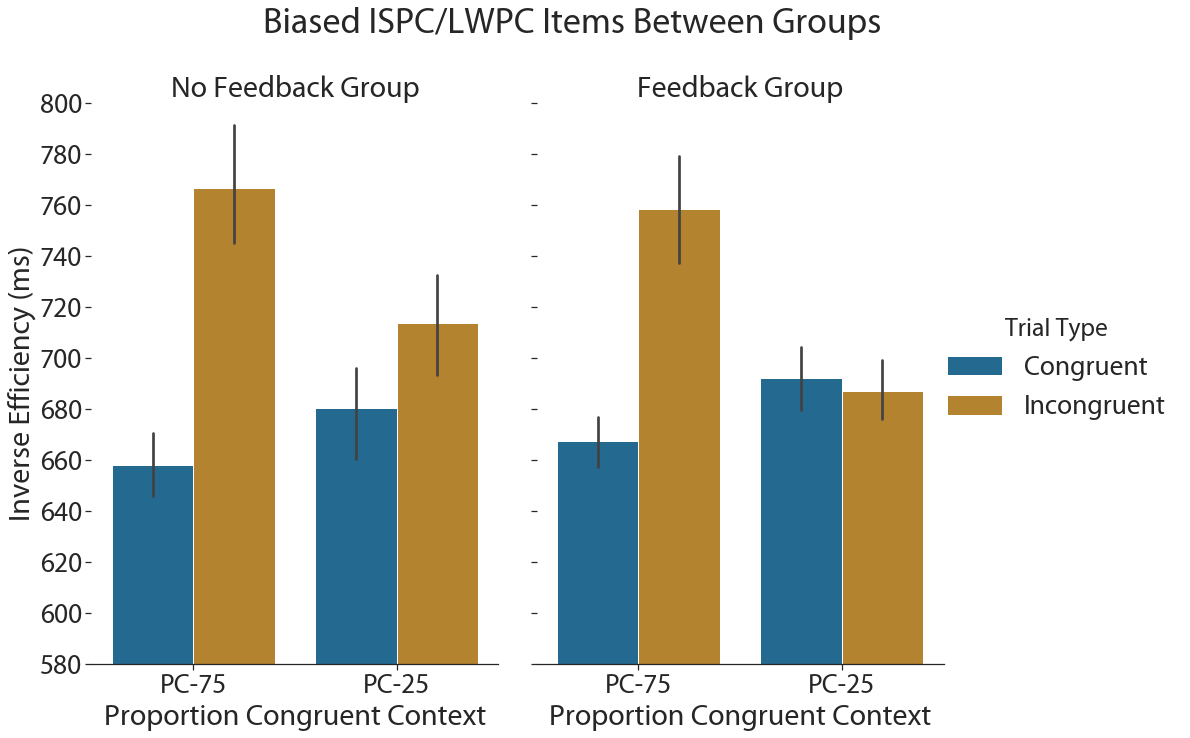

In [77]:
mybargraph("CueType","IE","TrialType","Feedback",["PC-75", "PC-25"],IE_all,"Proportion Congruent Context","Inverse Efficiency (ms)","Biased ISPC/LWPC Items Between Groups","Trial Type",580,800,"LWPC_IE_biased.png",20)

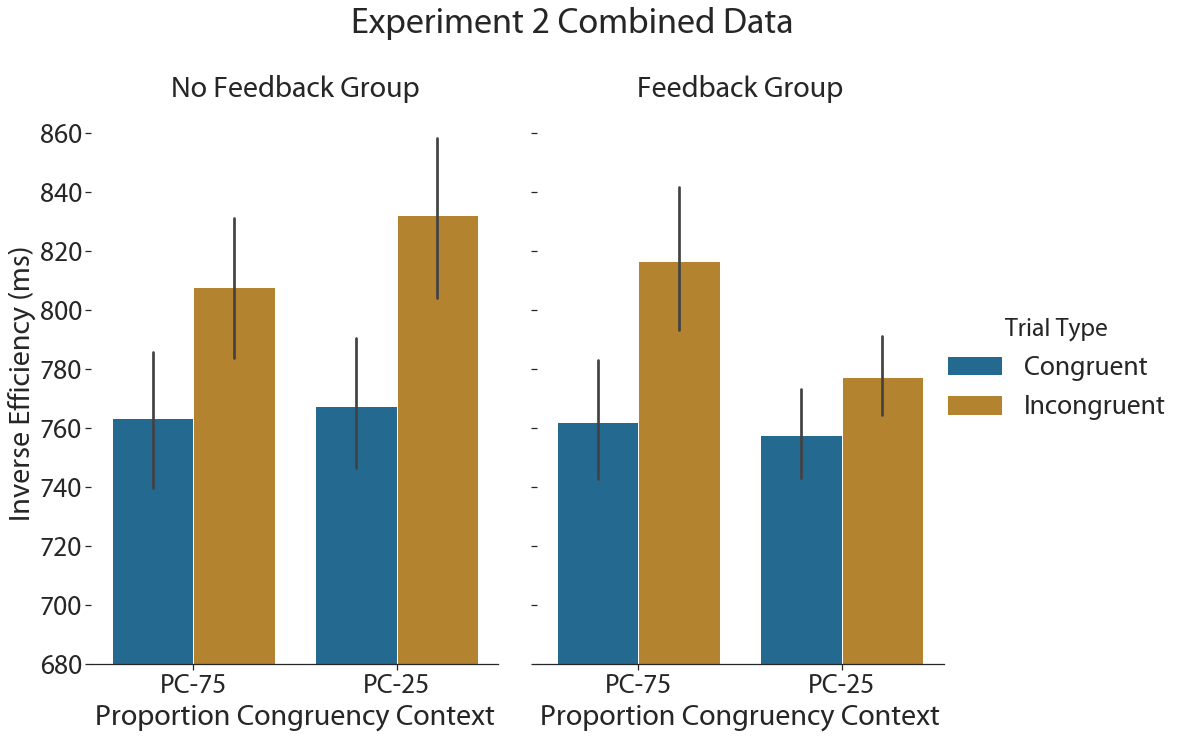

In [78]:
mybargraph("CueType","IE","TrialType","Feedback",["PC-75", "PC-25"],IE_all_T,"Proportion Congruency Context","Inverse Efficiency (ms)","Experiment 2 Combined Data","Trial Type",680,870,"LWPC_IE_unbiased.png",20)

In [85]:
%%writefile IE_Anova.R

install.packages("afex",repos='https://mirrors.nics.utk.edu/cran/')
library(afex)

rawIEData <- read.csv('IE_Main.csv')
aov_car(IE ~ Feedback * Experiment * BlockOrder + Error(subject/(Congruency*BlockType)), data = rawIEData, anova_table = list(es = "pes"))

#

rawIEData_T <- read.csv('IE_transfer.csv')
aov_car(IE ~ Feedback * Experiment * BlockOrder + Error(subject/(Congruency*BlockType)), data = rawIEData_T, anova_table = list(es = "pes"))

Overwriting IE_Anova.R


In [ ]:
! Rscript IE_Anova.R

Some things to observe:

* for *unbiased* items, there is an interaction between Feedback Group x Cue Type x Trial Type and a Block Order x Cue Type x Trial Type interaction.

* for *biased* items, there is a Cue Type x Trial Type interaction and a Cue Type x Trial Type x Block Order interaction. This, in essence, is similar to Experiment 1.

This suggests that proactive control (repped by the LWPC here) is sensitive to performance feedback, while reactive control (repped by the ISPC in E1 & ISPC/LWPC here) is not.

### Is there a correlation between the biased and unbiased effects?

In Gonthier et al. (2016), the claim is made that the ISPC reflects reactive control and the LWPC reflects proactive control, so the difference in congruency for items that are biased at the list & item level *should not* relate to the difference in congruency for items that are only biased at the list level.

Here, note that we have a decently large sample when all combined (N = 180). This is close to the sample size at which correlations tend to stabilize (200-250).

In [79]:
def my_corr_graphs(x, y, ylabel, xlabel, figname, selectsubs, corrxvalue, corryvalue):
    sns.jointplot(x=x, y=y, kind="reg", height=11, ratio=2, color = 'g');
    plt.ylabel(ylabel, fontweight="bold");
    plt.xlabel(xlabel, fontweight="bold");
    plb.savefig(figurepath+figname, dpi = 300)
    regstat = stats.linregress(x,y)
    
    if selectsubs == 1:
        corrx = x/corrxvalue
        corry = y/corryvalue
    else:
        corrx = x.reset_index(drop=True)/corrxvalue
        corry = y.reset_index(drop=True)/corryvalue
        
    corrstat = stats.linregress(corrx,corry)
    return regstat, corrstat

INVERSE EFFICIENCY

for the feedback group...?

(LinregressResult(slope=0.10599503940773422, intercept=24.574082009570525, rvalue=0.14845494838844306, pvalue=0.16258457026882941, stderr=0.07526799072338734),
 LinregressResult(slope=0.09873094891325397, intercept=0.025590000060968704, rvalue=0.14006803811137672, pvalue=0.18792948167321374, stderr=0.07439955878891921))

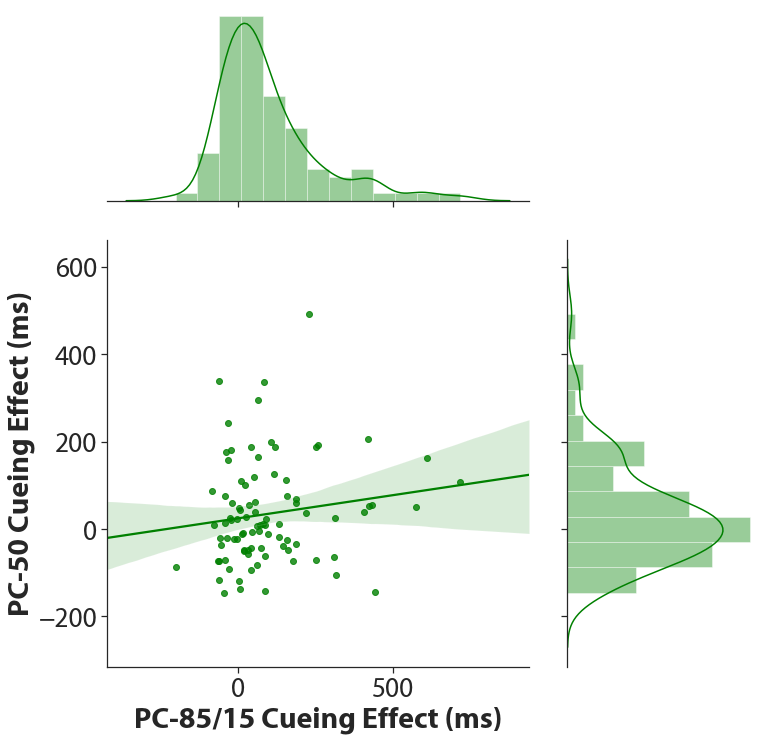

In [80]:
my_corr_graphs(avgIEmain.loc[avgIEmain.Feedback=="Feedback"].Effect, avgIE_T.loc[avgIE_T.Feedback=="Feedback"].Effect, 'PC-50 Cueing Effect (ms)', 'PC-85/15 Cueing Effect (ms)', "SC_SCT_All_IE_FB.png", 1, avgIEmain.loc[avgIEmain.Feedback=="Feedback"].OverallIE, avgIE_T.loc[avgIE_T.Feedback=="Feedback"].OverallIE)

for the no feedback group...?

(LinregressResult(slope=0.3884887185602794, intercept=-49.565145817675024, rvalue=0.47374312318684597, pvalue=2.4034805013952826e-06, stderr=0.07698461542119103),
 LinregressResult(slope=0.388191184621348, intercept=-0.05450698662986243, rvalue=0.4684135108699271, pvalue=3.2259399757514734e-06, stderr=0.07805236602393557))

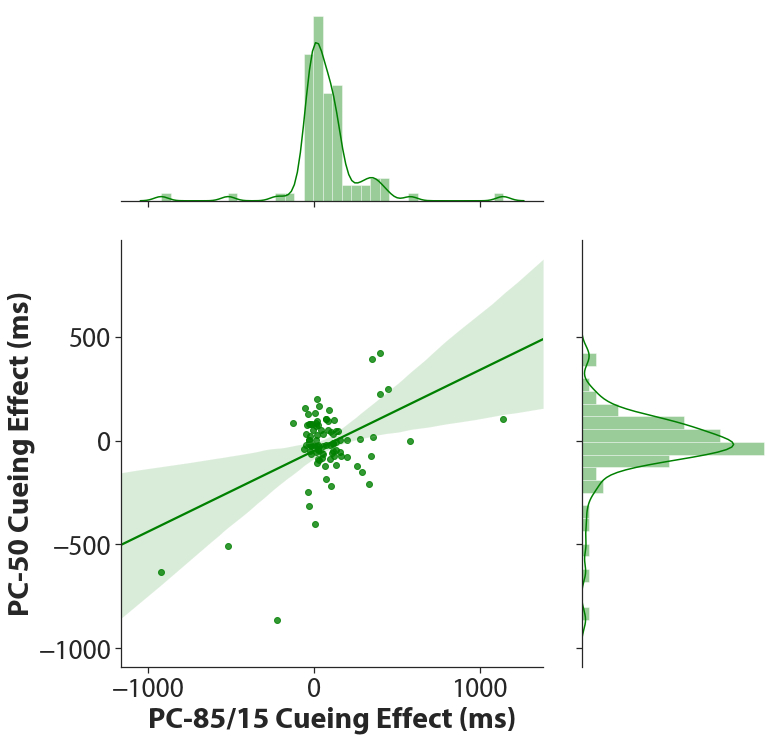

In [81]:
my_corr_graphs(avgIEmain.loc[avgIEmain.Feedback=="NoFeedback"].Effect, avgIE_T.loc[avgIE_T.Feedback=="NoFeedback"].Effect, 'PC-50 Cueing Effect (ms)', 'PC-85/15 Cueing Effect (ms)', "SC_SCT_All_IE_NoFB.png", 1, avgIEmain.loc[avgIEmain.Feedback=="NoFeedback"].OverallIE, avgIE_T.loc[avgIE_T.Feedback=="NoFeedback"].OverallIE)

for all subjects...?

(LinregressResult(slope=0.29031686721761296, intercept=-17.653662277503138, rvalue=0.36541574380459996, pvalue=4.5603389359574223e-07, stderr=0.05543092328359401),
 LinregressResult(slope=0.2766555618302177, intercept=-0.02005420234984355, rvalue=0.35037346457682944, pvalue=1.4231508528438881e-06, stderr=0.05543154999797228))

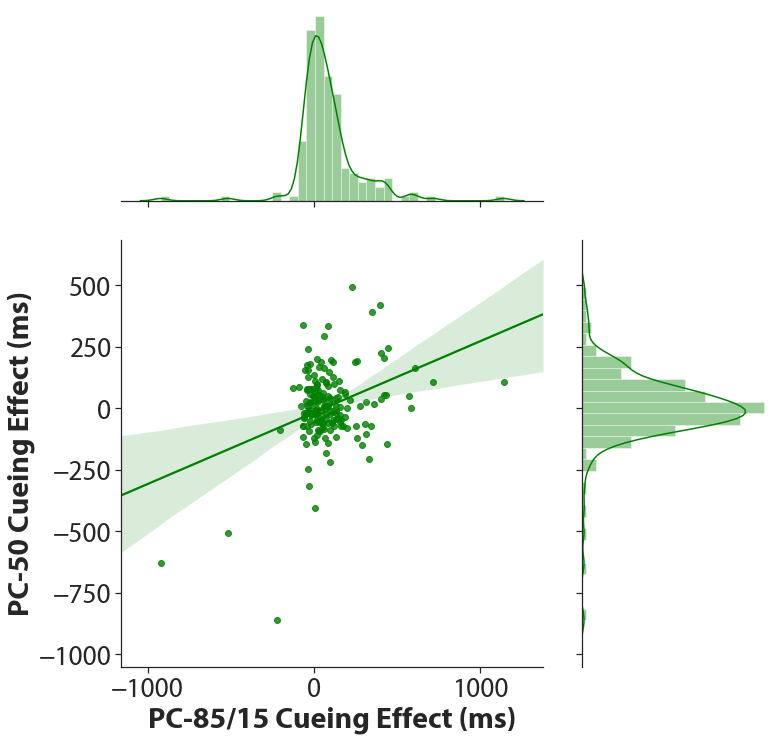

In [82]:
my_corr_graphs(avgIEmain.Effect, avgIE_T.Effect, 'PC-50 Cueing Effect (ms)', 'PC-85/15 Cueing Effect (ms)', "SC_SCT_All_IE.png", 1, avgIEmain.OverallIE, avgIE_T.OverallIE)

Here, we find some suggestion of a positive correlation between inverse efficiency scores for the LWPC and biased LWPC/ISPC effects. It's possible, despite the corrected correlation which is meant to shrink some of those massive outliers, that this is a result of the outliers. This might also be driven by accuracy, whereas the original Gonthier correlation is with RT.

REACTION TIME

for the feedback group...?

(LinregressResult(slope=-0.14055532566882303, intercept=10.18414414116553, rvalue=-0.22263749682704667, pvalue=0.03493165196213376, stderr=0.06560973880061056),
 LinregressResult(slope=-0.13109510351101528, intercept=0.015873663229014612, rvalue=-0.2237414893635683, pvalue=0.03401606334646042, stderr=0.060876074466207124))

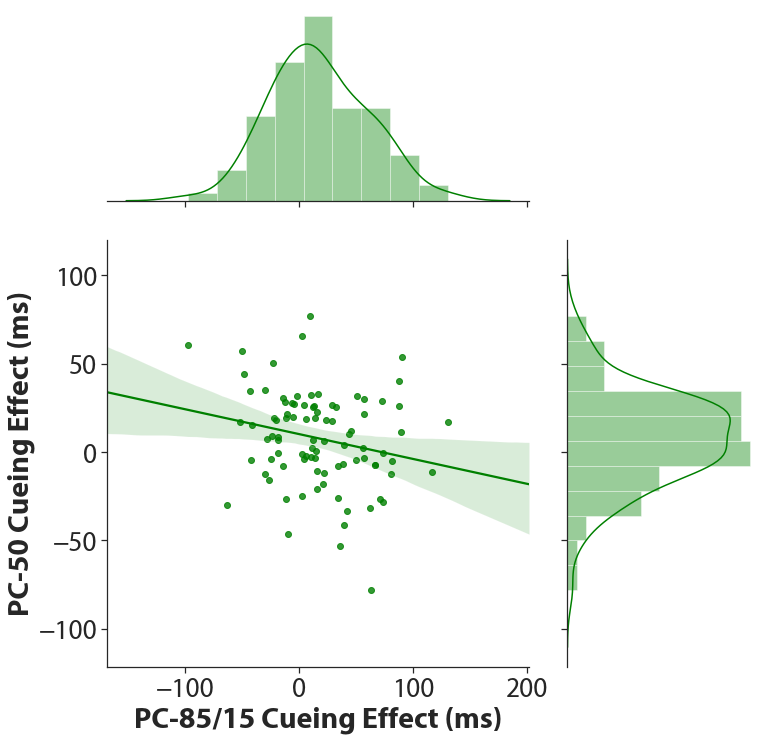

In [83]:
my_corr_graphs(SC_RT_FB.RTs, SCT_RT_FB.RTs, 'PC-50 Cueing Effect (ms)', 'PC-85/15 Cueing Effect (ms)', "SC_SCT_FB.png", 1, MainRT_FB.RT, RT_FB_T.RT)

for the no feedback group...?

(LinregressResult(slope=-0.04282165399814133, intercept=2.819318520026277, rvalue=-0.06738260468412971, pvalue=0.5280211612168015, stderr=0.06759057226950475),
 LinregressResult(slope=-0.04876247834182718, intercept=0.004522207412988328, rvalue=-0.08234317308299084, pvalue=0.4403704103833893, stderr=0.06291286700887311))

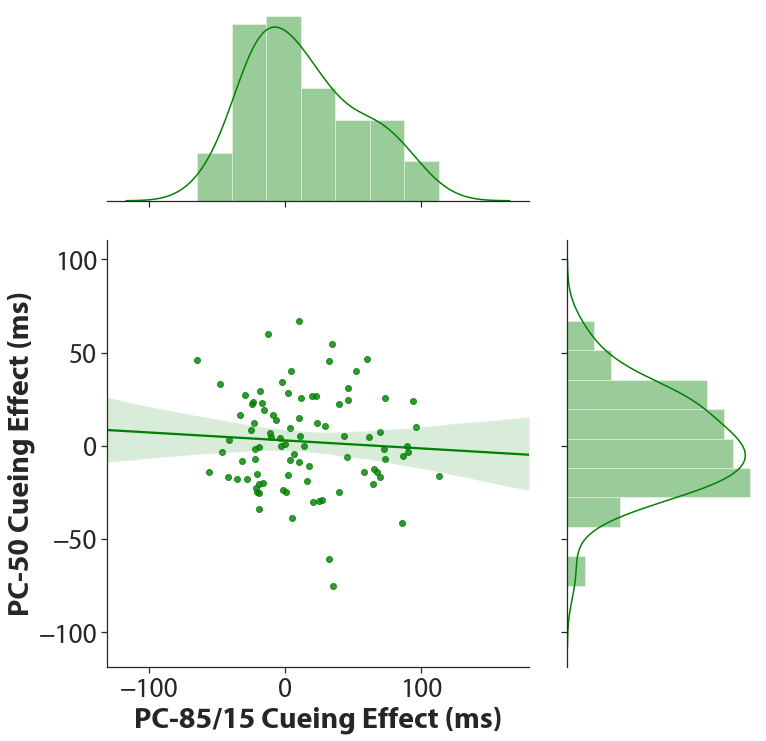

In [84]:
my_corr_graphs(SC_RT_NoFB.RTs, SCT_RT_NoFB.RTs, 'PC-50 Cueing Effect (ms)', 'PC-85/15 Cueing Effect (ms)', "SC_SCT_NoFB.png", 1, MainRT_NoFB.RT, RT_NoFB_T.RT)

across all subjects...?

(LinregressResult(slope=-0.09111813823179551, intercept=6.411406773426411, rvalue=-0.14319512363653977, pvalue=0.055152311139802575, stderr=0.04720279922197711),
 LinregressResult(slope=-0.08875702238948929, intercept=0.010055627331562463, rvalue=-0.14991387844872087, pvalue=0.044573266113148345, stderr=0.043874785245864696))

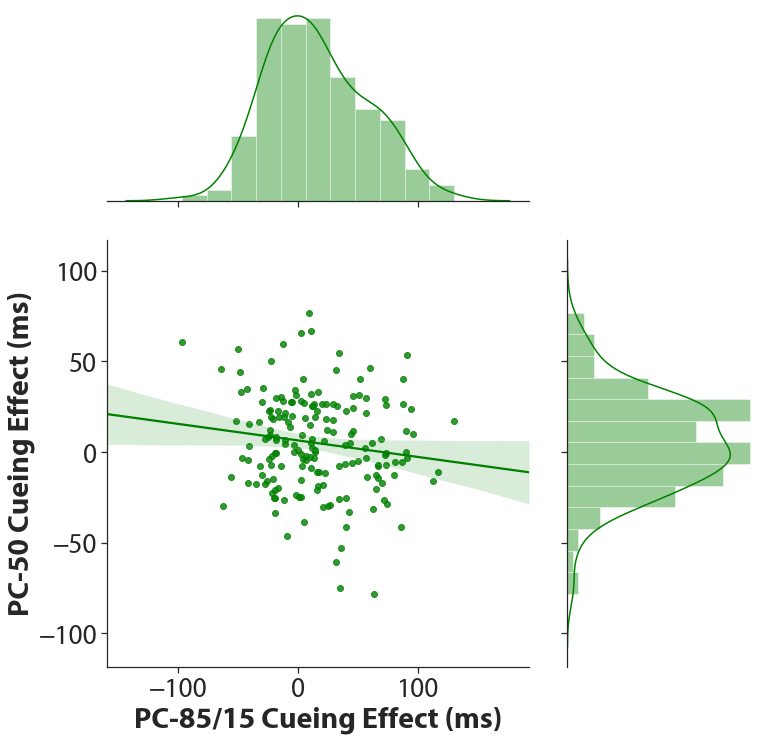

In [85]:
my_corr_graphs(SC_RT.RTs, SCT_RT.RTs, 'PC-50 Cueing Effect (ms)', 'PC-85/15 Cueing Effect (ms)', "SC_SCT_All.png", 0, overallMainRT.RT, overallRT_T.RT)

With RT, we find a significant, negative relationship between the two effects (much like Gonthier et al. (2016)).

#### What about for accuracy?

for the feedback group...?

(LinregressResult(slope=0.11696542261367192, intercept=-0.009568578384162025, rvalue=0.13560530705987256, pvalue=0.20252957008924374, stderr=0.09109808013611084),
 LinregressResult(slope=0.1198611970200889, intercept=-0.01459456556506786, rvalue=0.137400190085919, pvalue=0.19656280186724676, stderr=0.09211095143176035))

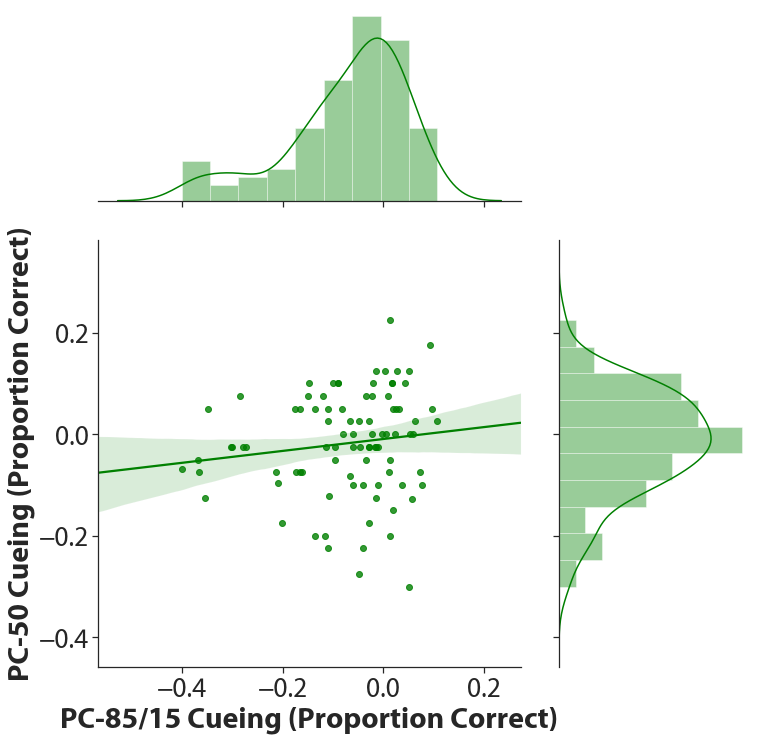

In [86]:
my_corr_graphs(SC_ACC_FB.ACC, SCT_ACC_FB.ACC, 'PC-50 Cueing (Proportion Correct)', 'PC-85/15 Cueing (Proportion Correct)', "SC_SCT_FB_ACC.png", 1, MainACC_FB.Accuracy, ACC_FB_T.Accuracy)

for the no feedback group...?

(LinregressResult(slope=0.4161759611894088, intercept=0.03436165101749364, rvalue=0.43880539066786806, pvalue=1.5168697586482537e-05, stderr=0.09084927679530623),
 LinregressResult(slope=0.459926817113705, intercept=0.0423708891024431, rvalue=0.486007827574807, pvalue=1.1978698274924365e-06, stderr=0.08816433456017882))

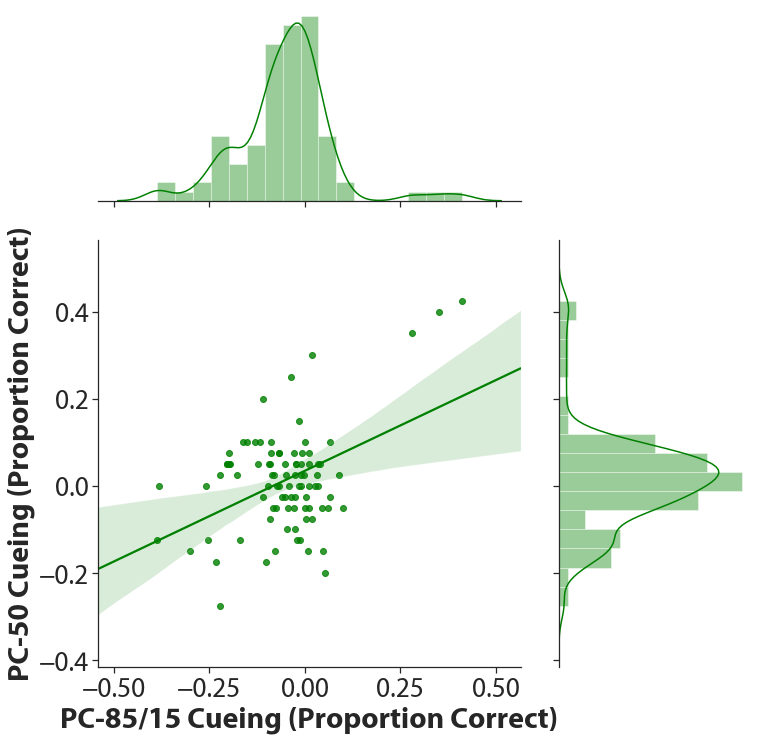

In [87]:
my_corr_graphs(SC_ACC_NoFB.ACC, SCT_ACC_NoFB.ACC, 'PC-50 Cueing (Proportion Correct)', 'PC-85/15 Cueing (Proportion Correct)', "SC_SCT_NoFB_ACC.png", 1, MainACC_NoFB.Accuracy, ACC_NoFB_T.Accuracy)

across all subjects...?

(LinregressResult(slope=0.2826173487866688, intercept=0.014908256466002336, rvalue=0.3090998760831774, pvalue=2.421700727270363e-05, stderr=0.06517544604297258),
 LinregressResult(slope=0.31538978824645697, intercept=0.017598611102034763, rvalue=0.3423326229084457, pvalue=2.553815093850572e-06, stderr=0.0648817508844273))

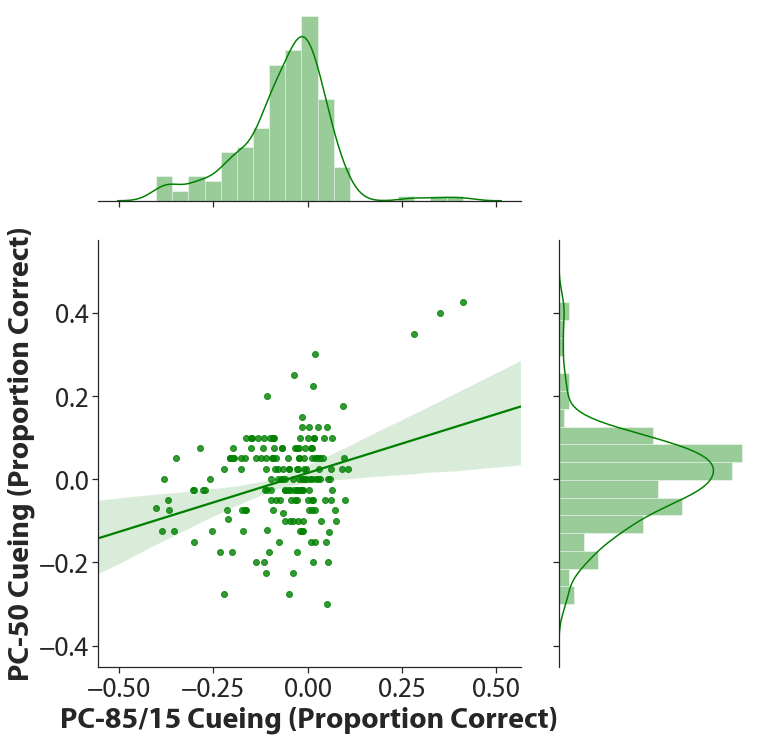

In [88]:
my_corr_graphs(SC_ACC.ACC, SCT_ACC.ACC, 'PC-50 Cueing (Proportion Correct)', 'PC-85/15 Cueing (Proportion Correct)', "SC_SCT_All_ACC.png", 0, overallMainACC.Accuracy, overallACC_T.Accuracy)

So, the positive relationship from inverse efficiency seems to stem in large part from the relationship between the 2 accuracy effects. Negative means they're showing the effect we're expecting (i.e., high PC/low control-demand congruency effect - low PC/high control-demand congruency effect). Hmmm... I guess this is in line with the speed-accuracy trade-offs; perhaps the different directions result from that...

# Making Supplementary Tables with 95% Confidence Intervals

Now I'm making the Supplementary tables that show our data in full, with 95% CIs accompanying the means.

In [89]:
import scipy.stats

#credit for simplifying code here: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, acc, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    #adding a rounded for the sake of the table
    if acc == 0:
        mrounded = np.round(m); lowerci = np.round(m-h); upperci = np.round(m+h)
    elif acc == 1: #can't fully round proportion correct, else it goes to 1.0!
        mrounded = np.round(m,decimals=2); lowerci = np.round(m-h,decimals=2); upperci = np.round(m+h, decimals=2)
    #return m, m-h, m+h
    return mrounded, [lowerci, upperci]

In [90]:
def ci_effects(df, dv, Filter1, Filter2, Filter3, Context):
    if Context == 1:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']==Filter2].loc[df['Feedback']==Filter3].groupby(['subject','ContextCong'])[dv].mean().reset_index()
    elif Context == 2:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']!=Filter2].loc[df['Feedback']==Filter3].groupby(['subject','ContextCong'])[dv].mean().reset_index()
    elif Context == 3:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']==Filter2].loc[df['Feedback']==Filter3].groupby(['subject','RunCounter','ContextCong'])[dv].mean().reset_index()
    elif Context == 4:
        sub_means = df.loc[df['Task']==Filter1].loc[df['Item']!=Filter2].loc[df['Feedback']==Filter3].groupby(['subject','RunCounter','ContextCong'])[dv].mean().reset_index()
        
    return sub_means

In [91]:
def make_ci_table(df, dv, Filter1, Filter2, Filter3, Context, Context2, RTacc, tablename):
    
    x = ci_effects(df, dv, Filter1, Filter2, Filter3, Context);
    overall_MIC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighIC'][dv],RTacc)
    overall_MIC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighC'][dv],RTacc)
    overall_MC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowIC'][dv],RTacc)
    overall_MC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowC'][dv],RTacc)
    
    x1 = ci_effects(df, dv, Filter1, Filter2, Filter3, Context2);
    r1_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 1][dv],RTacc)

    r2_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 2][dv],RTacc)

    r3_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    
    r4_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    r4_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    r4_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    r4_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    
    MyTable = pd.DataFrame({'Context.TrialType': ['MC.C', 'MC.IC', 'MIC.C', 'MIC.IC'],
                     'Run 1': [r1_MC_C, r1_MC_IC, r1_MIC_C, r1_MIC_IC],
                     'Run 2': [r2_MC_C, r2_MC_IC, r2_MIC_C, r2_MIC_IC],
                     'Run 3': [r3_MC_C, r3_MC_IC, r3_MIC_C, r3_MIC_IC],
                     'Run 4': [r4_MC_C, r4_MC_IC, r4_MIC_C, r4_MIC_IC],
                     'Overall': [overall_MC_C, overall_MC_IC, overall_MIC_C, overall_MIC_IC]})

    MyTable.to_csv(csvpath+tablename)
    return MyTable

First, let's look at the No Feedback Group for the PC-85/15 items

In [92]:
make_ci_table(cdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 2, 4, 0, 'NoFBSupplementaryTable1.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(633.0, [607.0, 659.0])","(624.0, [599.0, 649.0])","(589.0, [570.0, 608.0])","(591.0, [573.0, 610.0])","(609.0, [593.0, 625.0])"
1,MC.IC,"(656.0, [626.0, 685.0])","(650.0, [622.0, 678.0])","(622.0, [602.0, 643.0])","(618.0, [599.0, 637.0])","(637.0, [620.0, 653.0])"
2,MIC.C,"(628.0, [605.0, 651.0])","(599.0, [579.0, 619.0])","(615.0, [586.0, 644.0])","(612.0, [583.0, 640.0])","(613.0, [596.0, 630.0])"
3,MIC.IC,"(638.0, [618.0, 659.0])","(609.0, [590.0, 628.0])","(630.0, [603.0, 656.0])","(628.0, [600.0, 655.0])","(626.0, [610.0, 642.0])"


And now what about the feedback group for the biased items via RT?

In [93]:
make_ci_table(cdat, 'RT', 'Main', 'PC-50', 'Feedback', 2, 4, 0, 'FBSupplementaryTable2.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(635.0, [618.0, 652.0])","(623.0, [605.0, 641.0])","(611.0, [590.0, 631.0])","(611.0, [591.0, 631.0])","(620.0, [607.0, 633.0])"
1,MC.IC,"(660.0, [641.0, 679.0])","(647.0, [629.0, 666.0])","(634.0, [613.0, 655.0])","(628.0, [606.0, 650.0])","(642.0, [628.0, 655.0])"
2,MIC.C,"(624.0, [601.0, 648.0])","(620.0, [598.0, 641.0])","(626.0, [604.0, 648.0])","(626.0, [605.0, 647.0])","(624.0, [610.0, 639.0])"
3,MIC.IC,"(637.0, [616.0, 658.0])","(627.0, [608.0, 647.0])","(628.0, [609.0, 647.0])","(622.0, [603.0, 641.0])","(628.0, [615.0, 642.0])"


And for Accuracy, first for no feedback group, with biased items...

In [94]:
make_ci_table(adat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 2, 4, 1, 'NoFB_ACC_SupplementaryTable3.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(0.91, [0.87, 0.94])","(0.93, [0.91, 0.95])","(0.95, [0.94, 0.96])","(0.95, [0.93, 0.96])","(0.93, [0.92, 0.95])"
1,MC.IC,"(0.82, [0.76, 0.87])","(0.86, [0.81, 0.91])","(0.9, [0.86, 0.93])","(0.89, [0.86, 0.93])","(0.87, [0.84, 0.89])"
2,MIC.C,"(0.92, [0.89, 0.96])","(0.95, [0.93, 0.97])","(0.91, [0.88, 0.94])","(0.9, [0.86, 0.94])","(0.92, [0.9, 0.94])"
3,MIC.IC,"(0.86, [0.79, 0.92])","(0.94, [0.92, 0.96])","(0.92, [0.89, 0.94])","(0.9, [0.87, 0.93])","(0.9, [0.88, 0.92])"


And now for the feedback group, for accuracy, for biased items...

In [95]:
make_ci_table(adat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 2, 4, 1, 'FB_ACC_SupplementaryTable4.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(0.92, [0.9, 0.95])","(0.94, [0.92, 0.95])","(0.94, [0.92, 0.95])","(0.94, [0.92, 0.96])","(0.93, [0.92, 0.95])"
1,MC.IC,"(0.86, [0.8, 0.91])","(0.86, [0.82, 0.9])","(0.89, [0.86, 0.92])","(0.89, [0.86, 0.93])","(0.87, [0.85, 0.9])"
2,MIC.C,"(0.91, [0.87, 0.94])","(0.92, [0.9, 0.95])","(0.92, [0.89, 0.95])","(0.9, [0.88, 0.93])","(0.91, [0.9, 0.93])"
3,MIC.IC,"(0.91, [0.88, 0.94])","(0.93, [0.91, 0.95])","(0.93, [0.91, 0.95])","(0.93, [0.91, 0.95])","(0.92, [0.91, 0.94])"


#### now for unbiased items

no feedback group, unbiased, RT

In [96]:
make_ci_table(cdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 1, 3, 0, 'NoFBSupplementaryTable5.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(675.0, [646.0, 704.0])","(655.0, [629.0, 682.0])","(649.0, [627.0, 670.0])","(637.0, [619.0, 656.0])","(654.0, [638.0, 670.0])"
1,MC.IC,"(694.0, [666.0, 722.0])","(680.0, [655.0, 705.0])","(670.0, [648.0, 692.0])","(655.0, [632.0, 677.0])","(674.0, [658.0, 691.0])"
2,MIC.C,"(660.0, [639.0, 680.0])","(644.0, [625.0, 664.0])","(668.0, [643.0, 694.0])","(661.0, [633.0, 689.0])","(658.0, [642.0, 674.0])"
3,MIC.IC,"(690.0, [664.0, 716.0])","(659.0, [639.0, 680.0])","(684.0, [659.0, 710.0])","(679.0, [652.0, 705.0])","(676.0, [660.0, 693.0])"


feedback group, unbiased, RT

In [97]:
make_ci_table(cdat, 'RT', 'Main', 'PC-50', 'Feedback', 1, 3, 0, 'FBSupplementaryTable6.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(671.0, [651.0, 690.0])","(661.0, [643.0, 679.0])","(651.0, [630.0, 672.0])","(644.0, [623.0, 665.0])","(657.0, [643.0, 670.0])"
1,MC.IC,"(689.0, [667.0, 710.0])","(679.0, [660.0, 698.0])","(671.0, [652.0, 690.0])","(665.0, [644.0, 685.0])","(676.0, [663.0, 689.0])"
2,MIC.C,"(674.0, [652.0, 696.0])","(661.0, [641.0, 680.0])","(672.0, [653.0, 691.0])","(656.0, [637.0, 675.0])","(665.0, [652.0, 678.0])"
3,MIC.IC,"(685.0, [664.0, 705.0])","(668.0, [651.0, 686.0])","(687.0, [667.0, 708.0])","(669.0, [649.0, 689.0])","(677.0, [664.0, 690.0])"


no feedback group, unbiased Accuracy

In [98]:
make_ci_table(adat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 1, 3, 1, 'NoFB_ACC_SupplementaryTable7.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(0.85, [0.8, 0.9])","(0.88, [0.84, 0.92])","(0.92, [0.9, 0.94])","(0.89, [0.85, 0.93])","(0.88, [0.86, 0.91])"
1,MC.IC,"(0.82, [0.76, 0.88])","(0.87, [0.83, 0.91])","(0.88, [0.85, 0.92])","(0.9, [0.87, 0.93])","(0.87, [0.84, 0.89])"
2,MIC.C,"(0.88, [0.85, 0.92])","(0.92, [0.89, 0.94])","(0.88, [0.84, 0.92])","(0.85, [0.81, 0.9])","(0.88, [0.86, 0.91])"
3,MIC.IC,"(0.81, [0.74, 0.88])","(0.9, [0.87, 0.93])","(0.86, [0.82, 0.9])","(0.84, [0.79, 0.89])","(0.85, [0.82, 0.88])"


feedback group, unbiased Accuracy

In [99]:
make_ci_table(adat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 1, 3, 1, 'FB_ACC_SupplementaryTable8.csv')

,Context.TrialType,Run 1,Run 2,Run 3,Run 4,Overall
0,MC.C,"(0.85, [0.79, 0.9])","(0.88, [0.85, 0.92])","(0.91, [0.88, 0.94])","(0.91, [0.88, 0.94])","(0.89, [0.86, 0.91])"
1,MC.IC,"(0.79, [0.73, 0.86])","(0.85, [0.81, 0.89])","(0.89, [0.86, 0.92])","(0.91, [0.88, 0.94])","(0.86, [0.83, 0.89])"
2,MIC.C,"(0.89, [0.85, 0.93])","(0.9, [0.86, 0.93])","(0.89, [0.86, 0.92])","(0.89, [0.87, 0.92])","(0.89, [0.87, 0.91])"
3,MIC.IC,"(0.86, [0.82, 0.9])","(0.89, [0.86, 0.92])","(0.9, [0.87, 0.92])","(0.89, [0.86, 0.92])","(0.88, [0.87, 0.9])"


# Post-test Questionnaire Data

This was to assess participant awareness of the task manipulations.

In [102]:
%cd ..

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\lwpc_combined\data


In [103]:
posttest = pd.read_csv('posttest.csv')

In [104]:
#from: https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '({v:d})'.format(v=val)
    return my_autopct

In [105]:
from numpy import std, mean, sqrt

#correct if the population S.D. is expected to be equal for the two groups.
#from: https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

#### We assessed explicit awareness of the underlying task structures by asking participants whether they noticed any systematic variation in the image/Stroop trial sequences at the item and block level.

In [106]:
def mypiegraph(BlockorItem, title, figname):
    fig, ax1 = plt.subplots(figsize=(8, 7));
    if BlockorItem == 0:
        Q1 = [posttest.ItemVary[posttest.ItemVary == 1].count(), posttest.ItemVary[posttest.ItemVary == 0].count()];
    elif BlockorItem == 1:
        Q1 = [posttest.BlockVary[posttest.BlockVary == 1].count(), posttest.BlockVary[posttest.BlockVary == 0].count()];
    Q1labels = ['Yes','No'];
    plt.axis('equal');
    startanglept=90;
    radiussize=0.65;
    legendfontsize=15;
    titlefontsize=17;
    
    patches, texts, junk = ax1.pie(Q1, startangle=startanglept, radius=radiussize, autopct=make_autopct(Q1));
    ax1.legend(patches, Q1labels, loc='lower center', fontsize=legendfontsize, frameon=False);
    fig.suptitle(title, fontsize=titlefontsize,fontweight="bold", y = 0.85);
    plb.savefig(figurepath+figname, bbox_inches='tight');

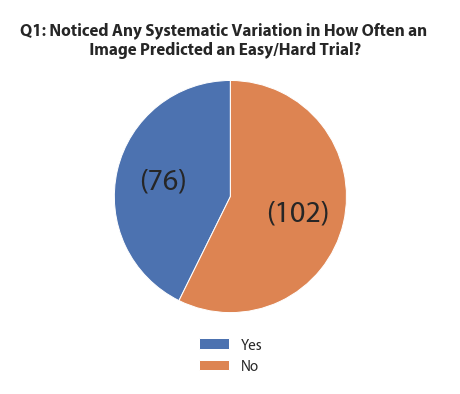

In [107]:
mypiegraph(0, 'Q1: Noticed Any Systematic Variation in How Often an\n Image Predicted an Easy/Hard Trial?', "posttestQ1_Item.png")

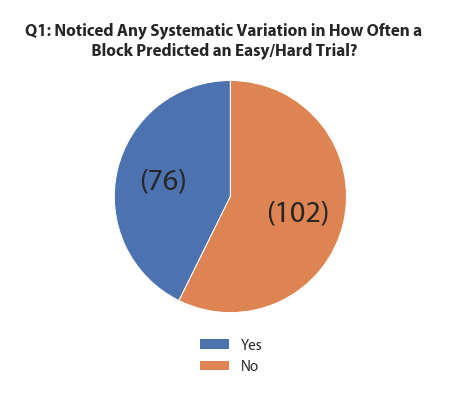

In [108]:
mypiegraph(1, 'Q1: Noticed Any Systematic Variation in How Often a\n Block Predicted an Easy/Hard Trial?', "posttestQ1_Block.png")

#### Next, we asked participants to rate how likely certain images would together predict the frequency of easy/congruent and hard/incongruent trials on a scale from 0 (never) to 100 (always). 

For instance, were the bear and bird paired together? Bear and deer? Bear and turtle?

Were any of the image category pairings rated as more predictive or nonpredictive than chance (50%)?

In [109]:
stats.ttest_1samp(posttest.FrequencyPredict_1.dropna(),50)

Ttest_1sampResult(statistic=-2.5168505874404494, pvalue=0.012729538596236626)

In [110]:
stats.ttest_1samp(posttest.FrequencyPredict_2.dropna(),50)

Ttest_1sampResult(statistic=-4.410940541469275, pvalue=1.7832198211022538e-05)

In [111]:
stats.ttest_1samp(posttest.FrequencyPredict_3.dropna(),50)

Ttest_1sampResult(statistic=-4.16000024282707, pvalue=4.9798781731732054e-05)

In [112]:
stats.ttest_1samp(posttest.FrequencyPredict_4.dropna(),50)

Ttest_1sampResult(statistic=-4.3076602769783285, pvalue=2.73757781398332e-05)

In [113]:
stats.ttest_1samp(posttest.FrequencyPredict_5.dropna(),50)

Ttest_1sampResult(statistic=-3.5936725957400233, pvalue=0.0004230595398181029)

Because the image pairs were randomized across participants, we wouldn't expect these to be more predictive than chance. Another way of analyzing this would be to look at for individuals who had bear + bird paired together, did they rate that one category higher? This analysis didn't turn out in the ISPC, and this would require me to hand-code each individual participant's post-test data, so I'm going to skip for now.

In [114]:
GRP_BT = posttest.groupby(['subjID'])['FrequencyPredict_1'].mean() #1 is bear + turtle
GRP_BTSEM = pd.Series.std(GRP_BT.dropna()) / sqrt(len(GRP_BT.dropna()))
GRP_BB = posttest.groupby(['subjID'])['FrequencyPredict_2'].mean() #2 is bear + bird
GRP_BBSEM = pd.Series.std(GRP_BB.dropna()) / sqrt(len(GRP_BB.dropna()))
GRP_BD = posttest.groupby(['subjID'])['FrequencyPredict_3'].mean() #3 is bear + deer
GRP_BDSEM = pd.Series.std(GRP_BD.dropna()) / sqrt(len(GRP_BD.dropna()))
GRP_BD2 = posttest.groupby(['subjID'])['FrequencyPredict_4'].mean() #4 is bear + dog
GRP_BD2SEM = pd.Series.std(GRP_BD2.dropna()) / sqrt(len(GRP_BD2.dropna()))
GRP_BC = posttest.groupby(['subjID'])['FrequencyPredict_5'].mean() #5 is bear + cat
GRP_BCSEM = pd.Series.std(GRP_BC.dropna()) / sqrt(len(GRP_BC.dropna()))

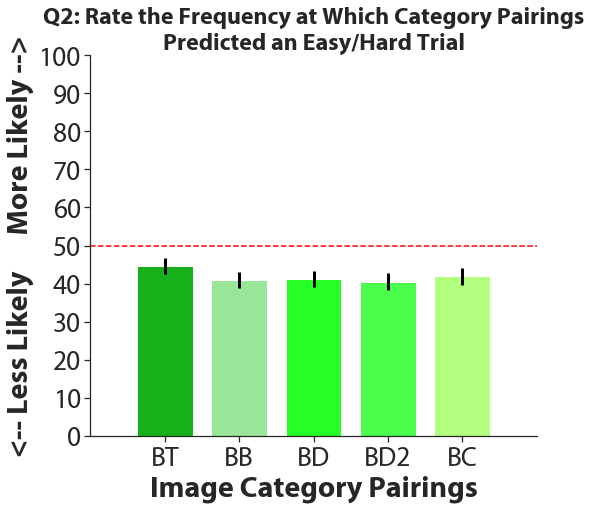

In [115]:
barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(8, 7));
plt.plot([0,1,2,3,4,5,6],[50,50,50,50,50,50,50], 'r--');
rects1 = ax.bar(1,GRP_BT.dropna().mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=GRP_BTSEM,ecolor='k',error_kw=dict(lw=3));
rects2 = ax.bar(2,GRP_BB.dropna().mean(),barwidth,color=(0.6,0.9,0.6),yerr=GRP_BBSEM,ecolor='k',error_kw=dict(lw=3));
rects3 = ax.bar(3,GRP_BD.dropna().mean(),barwidth,color=(0.15,1,0.15),yerr=GRP_BDSEM,ecolor='k',error_kw=dict(lw=3));
rects4 = ax.bar(4,GRP_BD2.dropna().mean(),barwidth,color=(0.3,1,0.3),yerr=GRP_BD2SEM,ecolor='k',error_kw=dict(lw=3));
rects5 = ax.bar(5,GRP_BC.dropna().mean(),barwidth,color=(0.7,1,0.5),yerr=GRP_BCSEM,ecolor='k',error_kw=dict(lw=3));
ax.set_ylim(0,100);
ax.set_xlim(0,6);
ax.set_xticklabels(('BT','BB','BD','BD2','BC'));
ax.set_xticks([1, 2, 3, 4, 5]);
ax.set_yticks(np.arange(0, 101, 10));
plt.title('Q2: Rate the Frequency at Which Category Pairings\nPredicted an Easy/Hard Trial', fontsize=24,fontweight="bold");
plt.ylabel('<-- Less Likely      More Likely -->', fontweight="bold");
plt.xlabel('Image Category Pairings',fontweight="bold");
sns.despine();

plb.savefig(figurepath+"posttestQ2.png", bbox_inches='tight');

#### Participants were then asked to match the images to the Stroop trial type that they most likely preceded. Did they perform better than chance (i.e., 2/6 cue-demand relationships correctly matched)? Unlike in the ISPC, chance here is 2/6 correct because the options were hard/incongruent, easy/congruent, and neutral; we put both the biased and unbiased items together in the SCForcedChoice question.

##### Note that we also separate out the biased images post-test question (testing against chance then as 4/3) and the unbiased images post-test question (testing against chance as 2/3).

In [116]:
stats.ttest_1samp(posttest.SCForcedChoice.dropna(),2)

Ttest_1sampResult(statistic=4.0600372460144225, pvalue=7.372923390042503e-05)

In [117]:
stats.ttest_1samp(posttest.SCForcedChoice_bias.dropna(),(4/3))

Ttest_1sampResult(statistic=5.055436121297711, pvalue=1.0705061770114528e-06)

In [118]:
stats.ttest_1samp(posttest.SCForcedChoice_LWPC.dropna(),(2/3))

Ttest_1sampResult(statistic=-0.8640728994070362, pvalue=0.3887239228792606)

That the overall grouping is significant and the biased grouping significant, but not the unbiased, suggests that the increased PC from the biased grouping is what drives the increased recognition. This is consistent with Blais et al. (2012) suggesting that the more extreme the PC manipulation, the more explicitly aware participants are of the manipulation.

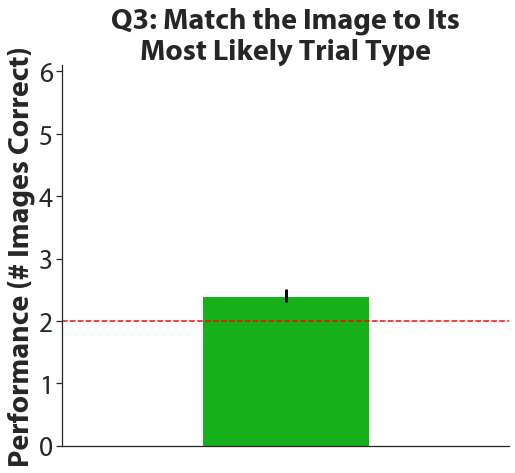

In [119]:
SCFC = posttest.groupby(['subjID'])['SCForcedChoice'].mean();
SCFCSEM = pd.Series.std(SCFC.dropna()) / sqrt(len(SCFC.dropna()));

barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(8, 7));
rects1 = ax.bar(1,SCFC.dropna().mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=SCFCSEM,ecolor='k',error_kw=dict(lw=3));
ax.set_ylim(0,6.1);
ax.set_xlim(0,2);
plt.plot([0,1,2],[2,2,2], 'r--');
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.set_yticks(np.arange(0, 7, 1));
plt.title('Q3: Match the Image to Its\nMost Likely Trial Type', fontweight="bold");
plt.ylabel('Performance (# Images Correct)', fontweight="bold");
sns.despine();

plb.savefig(figurepath+"posttestQ3.png", bbox_inches='tight');

# Exploratory Analysis of the Congruency Sequence Effect

This experiment was primarily designed to look at the effects of performance feedback on the LWPC. Here, this is just me satisfying my curiosity with an exploratory analysis of the CSE.

The CSE is also theorized to be sensitive to reward (Abrahamse et al., 2016). Thus, although the trial design is limited (not all the trial types have equal percentages), we can somewhat assess the effects of FB on the CSE.

In [120]:
rdat = dat.query('(TypeOfResponse != "SCRespITI") & (RT > 200) & (RT < 1000) & (Accuracy != 0) & (StimRep != 1) & (TrialCounter != 1)').copy()
acdat = dat.query('(TrialCounter != 1)').copy()

In [121]:
dataframes = [rdat, acdat];

for df in dataframes:
    df['Feedback'] = df['Version'].isin([3,4,9,10])
    df.loc[df['Version'].isin([9,10]), 'Feedback'] = 'Feedback'
    df.loc[df['Version'].isin([3,4]), 'Feedback'] = 'NoFeedback'
    
    df['BlockOrder'] = df['Version'].isin([3,4,9,10])
    df.loc[df['Version'].isin([3,9]), 'BlockOrder'] = 'IncongFirst'
    df.loc[df['Version'].isin([4,10]), 'BlockOrder'] = 'CongFirst'
    
    df['Task'] = df['RunCounter'].isin([4])
    df.loc[df['RunCounter'].isin([0]), 'Task'] = 'Practice'
    df.loc[df['RunCounter'].isin([1,2,3,4]), 'Task'] = 'Main'
    
    df['BlockType'] = df['ContextType'].isin([0])
    df.loc[df['ContextType'].isin([1]), 'BlockType'] = 'MIC/High'
    df.loc[df['ContextType'].isin([0]), 'BlockType'] = 'MC/Low'
    
    df['Item'] = df['ItemType'].isin([1])
    df.loc[df['ItemType'].isin([1]),'Item'] = 'PC-85'
    df.loc[df['ItemType'].isin([2]),'Item'] = 'PC-15'
    df.loc[df['ItemType'].isin([3]),'Item'] = 'PC-50'

    df['Congruency'] = df['TrialType'].isin([1])
    df.loc[df['TrialType'].isin([0]),'Congruency'] = 'Incongruent'
    df.loc[df['TrialType'].isin([1]),'Congruency'] = 'Congruent'
    
    df['PrevCong'] = df['Prevtrial'].isin([1])
    df.loc[df['Prevtrial'].isin([1]),'PrevCong'] = 'Incongruent'
    df.loc[~df['Prevtrial'].isin([1]),'PrevCong'] = 'Congruent'
    
    df['CSE'] = df['Sequential'].isin([1])
    df.loc[df['Sequential'].isin([1]),'CSE'] = 'Cong-Cong'
    df.loc[df['Sequential'].isin([2]),'CSE'] = 'Incong-Cong'
    df.loc[df['Sequential'].isin([3]),'CSE'] = 'Cong-Incong'
    df.loc[df['Sequential'].isin([4]),'CSE'] = 'Incong-Incong'

Let's take a peak at the means...

In [122]:
mean_cueing_effect(rdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 4) #pc-85/15 items

(CSE
 Cong-Cong        607.395403
 Cong-Incong      628.594004
 Incong-Cong      612.181950
 Incong-Incong    625.589495
 Name: RT, dtype: float64, CSE
 Cong-Cong        4.019774
 Cong-Incong      3.935256
 Incong-Cong      3.957990
 Incong-Incong    3.990300
 Name: RT, dtype: float64)

In [123]:
mean_cueing_effect(rdat, 'RT', 'Main', 'PC-50', 'NoFeedback', 3) #pc-50/50 items

(CSE
 Cong-Cong        657.337967
 Cong-Incong      670.358123
 Incong-Cong      653.844880
 Incong-Incong    680.917232
 Name: RT, dtype: float64, CSE
 Cong-Cong        4.164388
 Cong-Incong      4.106142
 Incong-Cong      3.948748
 Incong-Incong    4.125409
 Name: RT, dtype: float64)

In [124]:
mean_cueing_effect(rdat, 'RT', 'Main', 'PC-50', 'Feedback', 4) #pc-85/15 items

(CSE
 Cong-Cong        619.525570
 Cong-Incong      631.981856
 Incong-Cong      620.743802
 Incong-Incong    628.297500
 Name: RT, dtype: float64, CSE
 Cong-Cong        3.304667
 Cong-Incong      3.263008
 Incong-Cong      3.272372
 Incong-Incong    3.327988
 Name: RT, dtype: float64)

In [125]:
mean_cueing_effect(rdat, 'RT', 'Main', 'PC-50', 'Feedback', 3) #pc-50/50 items

(CSE
 Cong-Cong        661.562129
 Cong-Incong      674.329709
 Incong-Cong      659.885807
 Incong-Incong    677.336814
 Name: RT, dtype: float64, CSE
 Cong-Cong        3.349481
 Cong-Incong      3.229009
 Incong-Cong      3.256729
 Incong-Incong    3.248290
 Name: RT, dtype: float64)

In [126]:
mean_cueing_effect(acdat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 4) #pc-85/15 items

(CSE
 Cong-Cong        0.934160
 Cong-Incong      0.883326
 Incong-Cong      0.929582
 Incong-Incong    0.906316
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.003386
 Cong-Incong      0.004894
 Incong-Cong      0.003409
 Incong-Incong    0.005170
 Name: Accuracy, dtype: float64)

In [127]:
mean_cueing_effect(acdat, 'Accuracy', 'Main', 'PC-50', 'NoFeedback', 3) #pc-50/50 items

(CSE
 Cong-Cong        0.883524
 Cong-Incong      0.863777
 Incong-Cong      0.885722
 Incong-Incong    0.860070
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.005574
 Cong-Incong      0.006096
 Incong-Cong      0.005326
 Incong-Incong    0.006692
 Name: Accuracy, dtype: float64)

In [128]:
mean_cueing_effect(acdat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 4) #pc-85/15 items

(CSE
 Cong-Cong        0.935654
 Cong-Incong      0.902107
 Incong-Cong      0.927590
 Incong-Incong    0.927041
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.002729
 Cong-Incong      0.004299
 Incong-Cong      0.003206
 Incong-Incong    0.003391
 Name: Accuracy, dtype: float64)

In [129]:
mean_cueing_effect(acdat, 'Accuracy', 'Main', 'PC-50', 'Feedback', 3) #pc-50/50 items

(CSE
 Cong-Cong        0.889544
 Cong-Incong      0.861681
 Incong-Cong      0.892854
 Incong-Incong    0.885675
 Name: Accuracy, dtype: float64, CSE
 Cong-Cong        0.005508
 Cong-Incong      0.005639
 Incong-Cong      0.004474
 Incong-Incong    0.004689
 Name: Accuracy, dtype: float64)

OK, let's actually analyze the data... Note that there aren't enough trials to analyze PC-50 items. I am also leaving off Block Order because this is just exploratory anyway. Same about Experiment.

In [130]:
%cd csvdata

C:\Users\cb383\Desktop\YearThree\controllearning\fbproject\lwpc_combined\data\csvdata


In [131]:
CSE_RT = rdat.loc[rdat['Task'] == 'Main'].loc[rdat['Item'] != 'PC-50'].groupby(['subject','Feedback','PrevCong','Congruency'])['RT'].mean().reset_index();
CSE_ACC = acdat.loc[acdat['Task'] == 'Main'].loc[adat['Item'] != 'PC-50'].groupby(['subject','Feedback','PrevCong','Congruency'])['Accuracy'].mean().reset_index();

CSE_RT_T = rdat.loc[rdat['Task'] == 'Main'].loc[rdat['Item'] == 'PC-50'].groupby(['subject','Feedback','PrevCong','Congruency'])['RT'].mean().reset_index();
CSE_ACC_T = acdat.loc[acdat['Task'] == 'Main'].loc[acdat['Item'] == 'PC-50'].groupby(['subject','Feedback','PrevCong','Congruency'])['Accuracy'].mean().reset_index();

#create tidy data csvs
CSE_RT.to_csv(csvpath+'CSE_ANOVA_RT.csv')
CSE_ACC.to_csv(csvpath+'CSE_ANOVA_ACC.csv')
CSE_RT_T.to_csv(csvpath+'CSE_ANOVA_RT_T.csv')
CSE_ACC_T.to_csv(csvpath+'CSE_ANOVA_ACC_T.csv')

In [132]:
%%writefile CSEAnova.R

install.packages("psych",repos='https://mirrors.nics.utk.edu/cran/')
install.packages("ez",repos='https://mirrors.nics.utk.edu/cran/')
library(psych)
library(ez)

CSE_RT <- read.csv('CSE_ANOVA_RT.csv')

CSE_RT$subject = as.factor(CSE_RT$subject)
CSE_RT$Feedback = as.factor(CSE_RT$Feedback)
CSE_RT$PrevCong = as.factor(CSE_RT$PrevCong)
CSE_RT$Congruency = as.factor(CSE_RT$Congruency)

CSERT_AN <- ezANOVA(data=as.data.frame(CSE_RT),
                                  dv=.(RT),
                                  wid=.(subject),
                                  within=.(PrevCong, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(CSERT_AN)

#

CSE_ACC <- read.csv('CSE_ANOVA_ACC.csv')

CSE_ACC$subject = as.factor(CSE_ACC$subject)
CSE_ACC$Feedback = as.factor(CSE_ACC$Feedback)
CSE_ACC$PrevCong = as.factor(CSE_ACC$PrevCong)
CSE_ACC$Congruency = as.factor(CSE_ACC$Congruency)

CSEACC_AN <- ezANOVA(data=as.data.frame(CSE_ACC),
                                  dv=.(Accuracy),
                                  wid=.(subject),
                                  within=.(PrevCong, Congruency),
                                  between=.(Feedback),
                                  detailed=TRUE)
print(CSEACC_AN)

Writing CSEAnova.R


In [133]:
! Rscript CSEAnova.R

package 'psych' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\RtmpIDajGn\downloaded_packages
package 'ez' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\cb383\AppData\Local\Temp\RtmpIDajGn\downloaded_packages
$ANOVA
                        Effect DFn DFd          SSn        SSd            F
1                  (Intercept)   1 178 2.783673e+08 3237763.26 1.530358e+04
2                     Feedback   1 178 8.072890e+03 3237763.26 4.438170e-01
3                     PrevCong   1 178 5.264715e+00   36001.25 2.603019e-02
5                   Congruency   1 178 3.355787e+04   99253.59 6.018221e+01
4            Feedback:PrevCong   1 178 2.030274e+02   36001.25 1.003823e+00
6          Feedback:Congruency   1 178 2.396790e+03   99253.59 4.298370e+00
7          PrevCong:Congruency   1 178 1.812697e+03   41964.44 7.688892e+00
8 Feedback:PrevCong:Congruency   1 178 9.386150e+01   41964.

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/psych_1.8.12.zip'
Content type 'application/zip' length 5908111 bytes (5.6 MB)
downloaded 5.6 MB

trying URL 'https://mirrors.nics.utk.edu/cran/bin/windows/contrib/3.4/ez_4.4-0.zip'
Content type 'application/zip' length 332373 bytes (324 KB)
downloaded 324 KB

Warning message:
package 'psych' was built under R version 3.4.4 
Warning message:
package 'ez' was built under R version 3.4.4 


Let's look at the graphs...

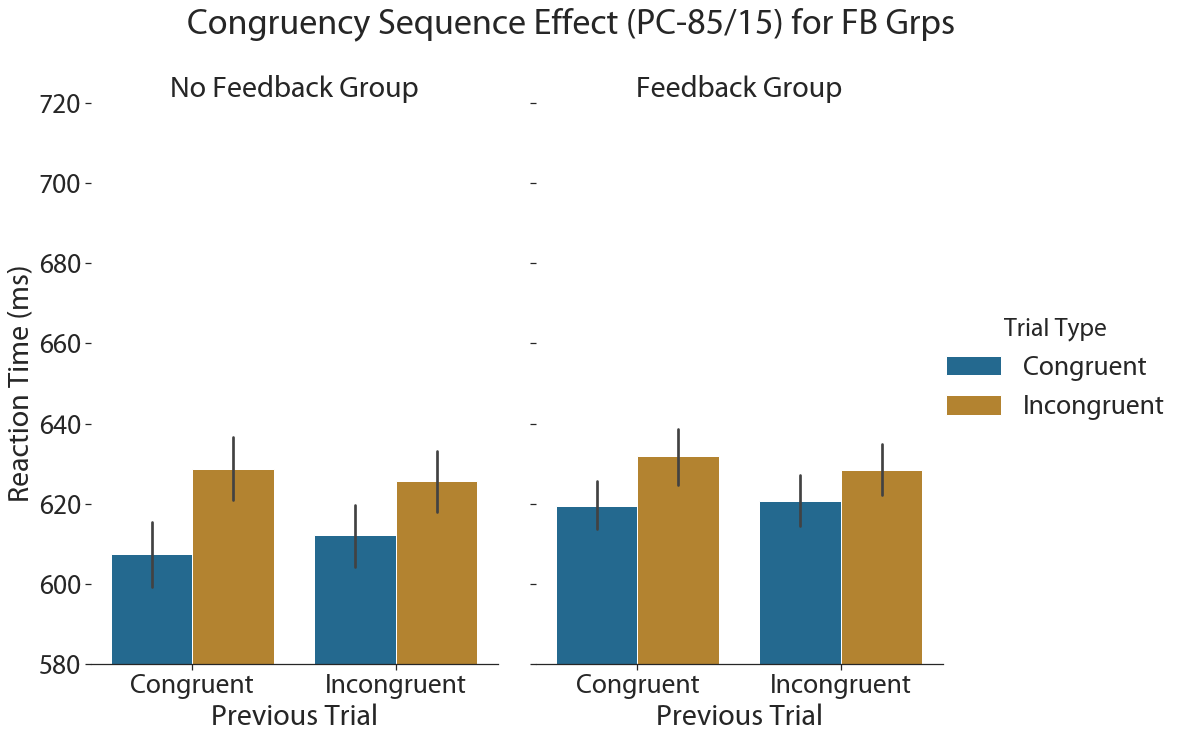

In [134]:
mybargraph("PrevCong","RT","Congruency","Feedback",["Congruent", "Incongruent"],CSE_RT,"Previous Trial","Reaction Time (ms)","Congruency Sequence Effect (PC-85/15) for FB Grps","Trial Type",580,720,"CSE_RT.png", 20)

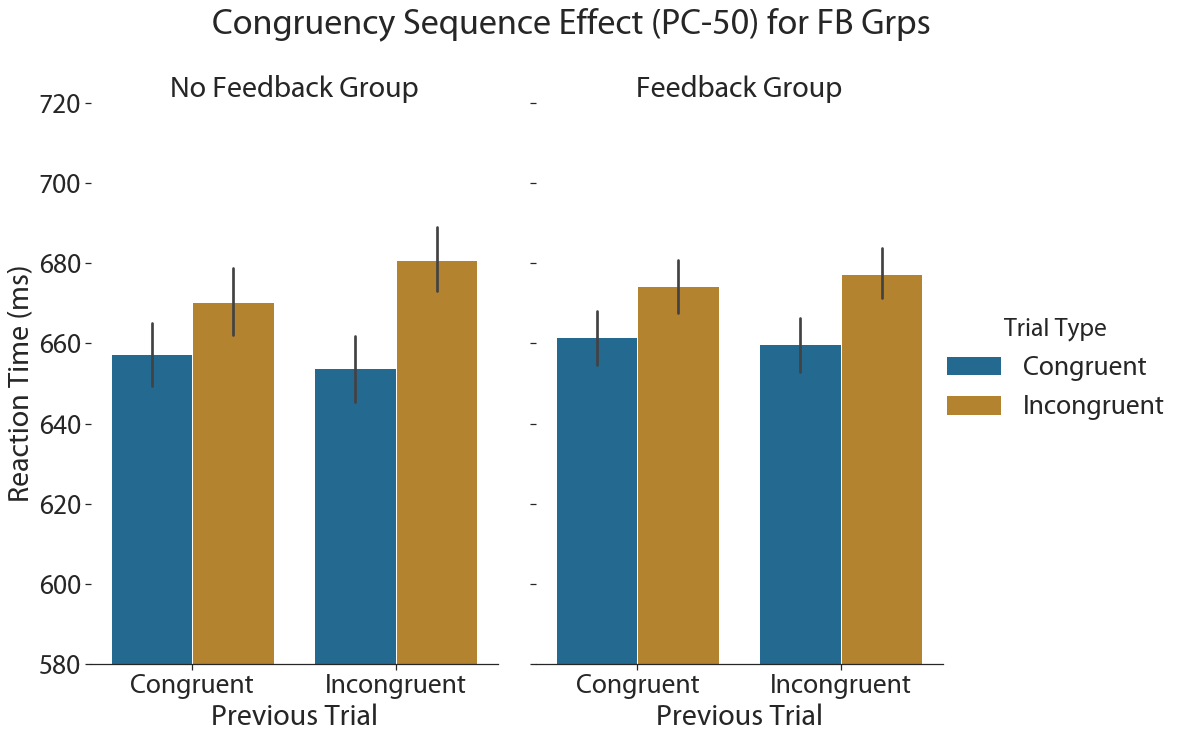

In [135]:
mybargraph("PrevCong","RT","Congruency","Feedback",["Congruent", "Incongruent"],CSE_RT_T,"Previous Trial","Reaction Time (ms)","Congruency Sequence Effect (PC-50) for FB Grps","Trial Type",580,720,"CSE_RT_T.png",20)

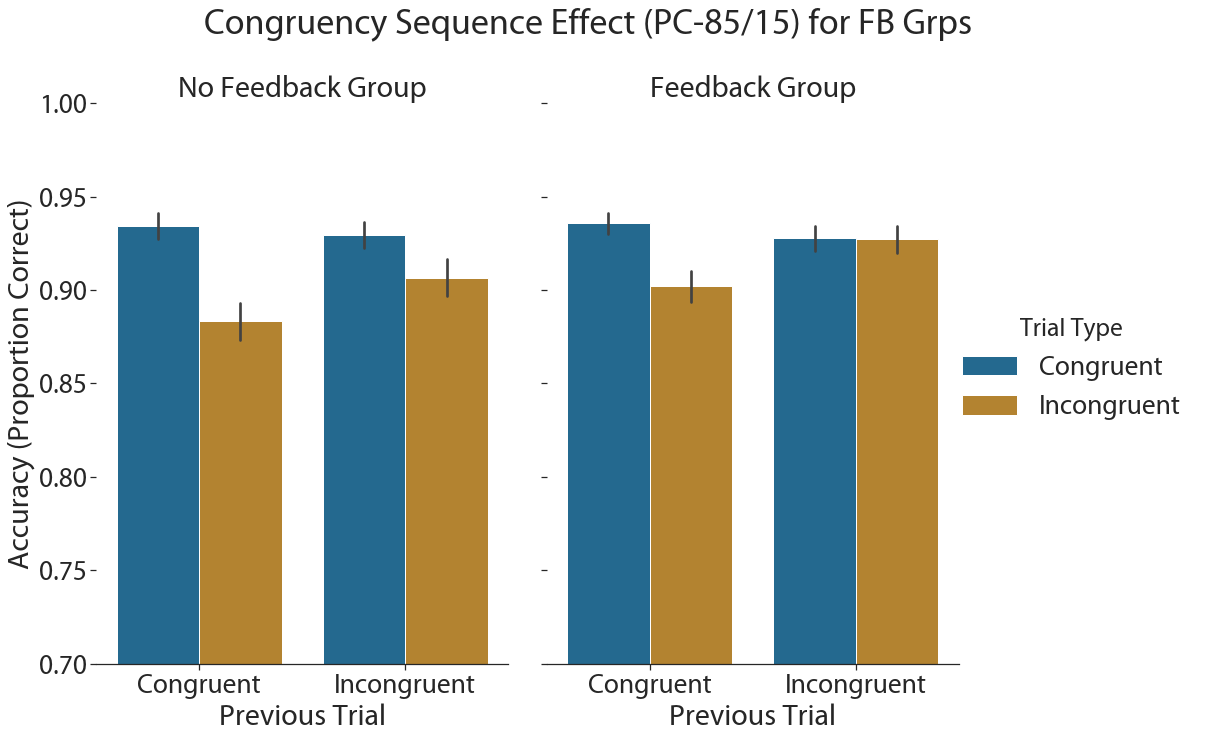

In [136]:
mybargraph("PrevCong","Accuracy","Congruency","Feedback",["Congruent", "Incongruent"],CSE_ACC,"Previous Trial","Accuracy (Proportion Correct)","Congruency Sequence Effect (PC-85/15) for FB Grps","Trial Type",0.7,1.0,"CSE_ACC.png",0.05)

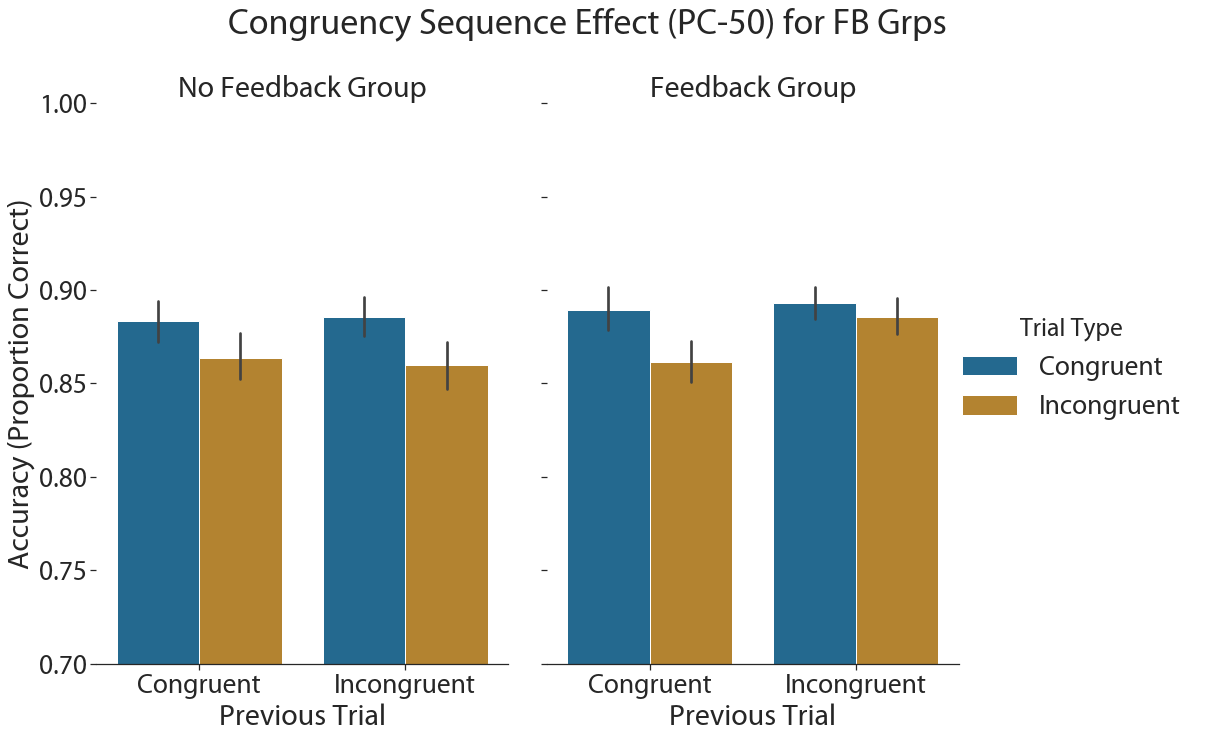

In [137]:
mybargraph("PrevCong","Accuracy","Congruency","Feedback",["Congruent", "Incongruent"],CSE_ACC_T,"Previous Trial","Accuracy (Proportion Correct)","Congruency Sequence Effect (PC-50) for FB Grps","Trial Type",0.7,1.0,"CSE_ACC_T.png",0.05)